In [2]:
import numpy as np
import pandas as pd
import cv2
import pickle
import matplotlib.pyplot as plt

import imutils
from shapely.geometry import Point, Polygon

import yolo3_one_file_to_detect_them_all as yolo3
import YOLOV3 as yolo3_custom
from keras.models import load_model

import progressbar
from datetime import datetime

%matplotlib inline

# Player Tracking

In [3]:
model = yolo3.make_yolov3_model()
weight_reader = yolo3.WeightReader('./data/weights/yolov3.weights')
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [4]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person"]

In [46]:
PATH = './data/xu_tomokazu_bank_of_communications_2020_set_1.mp4'
scaling_factor = 0.5

cap = cv2.VideoCapture(PATH)
ret, img = cap.read()
print(img.shape)
new_h, new_w = int(img.shape[1]*scaling_factor), int(img.shape[0]*scaling_factor)
img = cv2.resize(img, (new_h, new_w), interpolation=cv2.INTER_AREA)
h, w, _ = img.shape

(720, 1280, 3)


In [6]:
src_pts = np.array([
    [1, 86], 
    [1, 326], 
    [413, 326], 
    [413, 86]
])

dst_pts = np.array([
      [1,  1],     
      [1,  413],    
      [415,  415],    
      [415,  1],  
    ])

In [7]:
def drawPlayers(im, pred_boxes, pred_classes, showResult=False):
    
    color = [255, 0, 0]
    thickness = 3
    radius = 3

    i  = 0
    for box in pred_boxes:

        # Include only class Person
        ##if pred_classes[i] == 'Person':  

        x1 = int(box.xmin)
        y1 = int(box.ymin)
        x2 = int(box.xmax)
        y2 = int(box.ymax)

        xc = x1 + int((x2 - x1)/2)
        player_pos = (xc - 1, y2 - 25)

        court = Polygon(src_pts)

        # Draw only players that are within the court
        if (box.classes[0] > obj_thresh) & (Point(player_pos).within(court)):
            # ignore the umpire on the left side
            if xc == 21 and y2 == 205:
                continue
            if showResult:
                print("[% 3d, % 3d]" %(xc, y2))

            cv2.circle(im, player_pos, radius, color, thickness)
            i = i + 1            

    if showResult:
        plt.imshow(im)
#         cv2.imshow('Court', im)
        
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()        

person: 75.28159618377686%
person: 95.3445315361023%


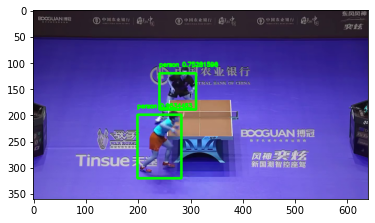

In [8]:
img_copy = yolo3.preprocess_input(img, net_h, net_w)
preds = model.predict(img_copy)
bboxes = []

for i in range(len(preds)):
    bboxes += yolo3.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

yolo3.correct_yolo_boxes(bboxes, h, w, net_h, net_w)
yolo3.do_nms(bboxes, nms_thresh)
obj = yolo3.draw_boxes(img, bboxes, labels, obj_thresh)

plt.imshow(img)
# cv2.imshow('YOLO prediction', img)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

[ 276,  189]
[ 241,  320]


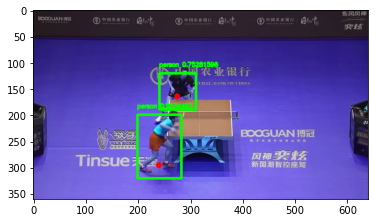

In [9]:
drawPlayers(obj, bboxes, labels, showResult=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


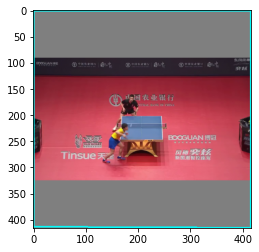

In [10]:
im_poly = img_copy[0].copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [dst_pts], isClosed=True, color=[0,255,255], thickness=2)
plt.imshow(im_poly)
# cv2.imshow('Court', im_poly)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [11]:
def homographyTransform(img_src, img_dst, showResult=False):

    # Calculate Homography
    h, status = cv2.findHomography(src_pts, dst_pts)
    img_out = cv2.warpPerspective(img_src, h, (img_dst.shape[1], img_dst.shape[0]))
    
    if showResult:
        plt.imshow(img_out)
#         cv2.imshow('Court', img_out)
        
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

    return img_out

def getPlayersMask(im):
    lower_range = np.array([255,0,0])                         # Set the Lower range value of blue in BGR
    upper_range = np.array([255,155,155])                     # Set the Upper range value of blue in BGR
    mask = cv2.inRange(im, lower_range, upper_range)          # Create a mask with range
    result = cv2.bitwise_and(im, im, mask = mask)             # Performing bitwise and operation with mask in img variable
    # cv2_imshow(result)                              

    return cv2.inRange(result, lower_range, upper_range)  

(360, 640, 3)

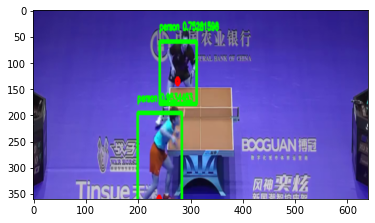

In [12]:
court = cv2.imread('./data/table_tennis_court_2.png')
court = cv2.resize(court, (w,h))

img_homography = homographyTransform(img, court, showResult=True)
img_homography.shape

In [13]:
court.shape

(360, 640, 3)

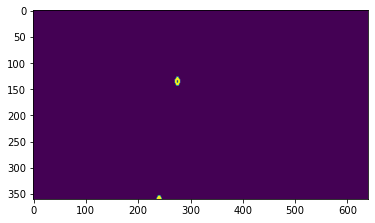

In [14]:
mask = getPlayersMask(img_homography)
plt.imshow(mask)

In [15]:
def drawPlayersOnCourt(im, coord, color, radius=10):
    for player_pos in coord:
        center = (player_pos[0], player_pos[1])
        cv2.circle(im, center, radius, color, thickness=-1)
        
    return im

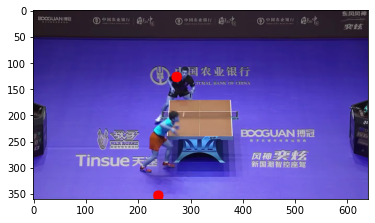

In [16]:
contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

color = [255,0,0]

if contours is not None:
#     print('masuk')
    for cont in contours:
        res = drawPlayersOnCourt(court, cont[0], color)
        
plt.imshow(court)
plt.show()
# cv2.imshow('court', court)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [17]:
PATH = './data/xu_tomokazu_bank_of_communications_2020_set_1.mp4'
scaling_factor = 0.5

cap = cv2.VideoCapture(PATH)
ret, img = cap.read()
new_h, new_w = int(img.shape[0]*scaling_factor), int(img.shape[1]*scaling_factor)
new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

player_info = {'player_A': {'label': 'Player A', 'player_coords': [], 'player_torso': [], 'tracking_coords': []},
               'player_B': {'label': 'Player B', 'player_coords': [], 'player_torso': [], 'tracking_coords': []},
              }

n_frame = 1
bboxes = []

img_h, img_w, _ = new_img.shape
input_img = yolo3_custom.preprocess_input(new_img, net_h, net_w)
preds = model.predict(input_img)

for i in range(len(preds)):
    bboxes += yolo3_custom.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)
    
yolo3_custom.correct_yolo_boxes(bboxes, img_h, img_w, net_h, net_w)
yolo3_custom.do_nms(bboxes, nms_thresh)
image = yolo3_custom.draw_boxes(new_img, n_frame, bboxes, labels, obj_thresh, src_pts, player_info, player=player_info['player_A']['label'])

In [18]:
player1 = 'Xu Xin'
player_info['player_A']['coords'] = player1

In [19]:
cv2.imshow('player', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ 276,  189]
[ 241,  320]


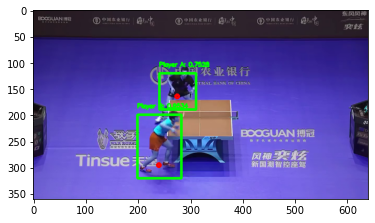

In [20]:
drawPlayers(image, bboxes, labels, showResult=True)

In [56]:
vid_path = './data/xu_tomokazu_bank_of_communications_2020_set_1.mp4'
save_path = './data/xu_tomokazu_bank_of_communications_2020_set_1_result.mp4'

cap = cv2.VideoCapture(vid_path)

scaling_factor = 0.5
video_FourCC = int(cap.get(cv2.CAP_PROP_FOURCC))
video_fps    = cap.get(cv2.CAP_PROP_FPS)
video_size   = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)*scaling_factor), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)*scaling_factor))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# print('Expected dimension:', video_size)

writer = None
grabbed = True
frame_number = 0

PLAYER_1 = 'Xu Xin'
PLAYER_2 = 'Tomokazu Harimoto'
player_info = {'player_A': {'label': PLAYER_1, 'player_coords': [], 'player_torso': [], 'tracking_coords': []},
               'player_B': {'label': PLAYER_2, 'player_coords': [], 'player_torso': [], 'tracking_coords': []},
              }

writer = cv2.VideoWriter(save_path, -1, video_fps, video_size)
bar = progressbar.ProgressBar(maxval=n_frames, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
start_time = datetime.now()

coordinates = []
while grabbed:
    frame_number += 1
    grabbed, frame = cap.read()
#     print('Before resize:', frame.shape)
        
    if grabbed:
        # image scaling
#         scaling_factor = 0.5
#         new_h, new_w = int(frame.shape[1]*scaling_factor), int(frame.shape[0]*scaling_factor)
        frame = cv2.resize(frame, (video_size[0], video_size[1]), interpolation=cv2.INTER_AREA)
#         print('After resize:', frame.shape)
#         h, w, _ = frame.shape
        
        # players' positions
        frame_h, frame_w, _ = frame.shape
        new_frame = yolo3_custom.preprocess_input(frame, net_h, net_w)
        
        preds = model.predict(new_frame)
        bboxes = []
        for i in range(len(preds)):
            bboxes += yolo3_custom.decode_netout(preds[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)
        
        yolo3_custom.correct_yolo_boxes(bboxes, frame_h, frame_w, net_h, net_w)
        yolo3_custom.do_nms(bboxes, nms_thresh)
        frame = yolo3_custom.draw_boxes(frame, frame_number, bboxes, labels, obj_thresh, src_pts, player_info, player=player_info['player_A']['label'])
        
        # court
#         court_copy = court_img.copy()
#         drawPlayers(frame, bboxes, labels, showResult=False)
#         homography_frame = homographyTransform(frame, court_copy, showResult=False)
#         player_mask = getPlayersMask(homography_frame)
        
#         contours = cv2.findContours(player_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         contours = imutils.grab_contours(contours)
#         if contours is not None:
#             for c in contours:
#                 res = drawPlayersOnCourt(court_copy, c[0], color)
#                 coordinates.append(c[0])

        # write to video
        writer.write(frame)
        
#         cv2.imshow('Final Result', frame)
#         if cv2.waitKey(1) & 0XFF == ord('q'):
#             break
    
        bar.update(frame_number)
    
    else:
        grabbed = False
        
# cv2.imshow('Result', res)
# data = pd.DataFrame(np.squeeze(coordinates), columns=['player_x', 'player_y'])
# data.to_csv('./data/ml_fzd_bank_of_communications_final_2020.csv')

print("Finished")
print("Elapsed time:", datetime.now() - start_time)
writer.release()
cap.release()
cv2.destroyAllWindows()

pickle.dump(player_info, open('./data/xu_tomokazu_bank_of_communications_2020_set_1.pkl', 'wb'))

[16 15 40]
frame: 2 .. player: Xu Xin .. torso_frame: [[16 15 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.01004888913107 .. cos_sim_B: 125.45669437210344
[ 39 215 246]
frame: 2 .. player: Tomokazu Harimoto .. torso_frame: [[ 39 215 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 111.39285532834396 .. cos_sim_B: 12.704504322127365
[19 15 34]
frame: 3 .. player: Xu Xin .. torso_frame: [[19 15 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.47301128745635 .. cos_sim_B: 130.77804599521687
[ 15 110 170]
frame: 3 .. player: Tomokazu Harimoto .. torso_frame: [[ 15 110 170]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 81.60719847223532 .. cos_sim_B: 41.46963374581813
[19 15 34]
frame: 4 .. player: Xu Xin .. torso_frame: [[19 15 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.47301128745635 .. cos_sim_B: 130.77804599521687
[ 19 118 166]
frame: 4 .. player: Tomokaz

[20 18 30]
frame: 32 .. player: Xu Xin .. torso_frame: [[20 18 30]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.31731201339821 .. cos_sim_B: 123.11211101887771
[ 30 238 253]
frame: 32 .. player: Tomokazu Harimoto .. torso_frame: [[ 30 238 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.32151085101846 .. cos_sim_B: 22.07861436347138
[22 20 32]
frame: 33 .. player: Xu Xin .. torso_frame: [[22 20 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.75301752725045 .. cos_sim_B: 121.15981507997562
[ 30 242 253]
frame: 33 .. player: Tomokazu Harimoto .. torso_frame: [[ 30 242 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.38275667310123 .. cos_sim_B: 23.930538588308337
[24 22 34]
frame: 34 .. player: Xu Xin .. torso_frame: [[24 22 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.37921274560725 .. cos_sim_B: 119.27136481509741
[ 26 253 246]
frame: 34 .. player: 

[27 21 47]
frame: 63 .. player: Xu Xin .. torso_frame: [[27 21 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.87468627675602 .. cos_sim_B: 129.84778374924647
[ 36 227 240]
frame: 63 .. player: Tomokazu Harimoto .. torso_frame: [[ 36 227 240]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.93366255597117 .. cos_sim_B: 20.737045140343213
[26 20 44]
frame: 64 .. player: Xu Xin .. torso_frame: [[26 20 44]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.55077715664977 .. cos_sim_B: 130.51842406954032
[ 40 224 238]
frame: 64 .. player: Tomokazu Harimoto .. torso_frame: [[ 40 224 238]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.83705364156548 .. cos_sim_B: 19.868703358932873
[26 14 48]
frame: 65 .. player: Xu Xin .. torso_frame: [[26 14 48]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 50.13848831254221 .. cos_sim_B: 138.5740761698166
[ 43 230 248]
frame: 65 .. player: 

[17 16 33]
frame: 94 .. player: Xu Xin .. torso_frame: [[17 16 33]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.92706378399132 .. cos_sim_B: 124.59498207548737
[ 42 244 255]
frame: 94 .. player: Tomokazu Harimoto .. torso_frame: [[ 42 244 255]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.93794896503388 .. cos_sim_B: 24.28879600778255
[20 18 30]
frame: 95 .. player: Xu Xin .. torso_frame: [[20 18 30]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.31731201339821 .. cos_sim_B: 123.11211101887771
[ 62 247 251]
frame: 95 .. player: Tomokazu Harimoto .. torso_frame: [[ 62 247 251]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 121.17982448589167 .. cos_sim_B: 27.004454031516314
[30 24 55]
frame: 96 .. player: Xu Xin .. torso_frame: [[30 24 55]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 39.405485339732 .. cos_sim_B: 128.01114725851343
[ 55 251 255]
frame: 96 .. player: To

[40 37 36]
frame: 125 .. player: Xu Xin .. torso_frame: [[40 37 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 72.10946010117806 .. cos_sim_B: 92.19684288332314
[ 65  86 104]
frame: 125 .. player: Tomokazu Harimoto .. torso_frame: [[ 65  86 104]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 94.44124621178901 .. cos_sim_B: 50.69170350573633
[24 25 30]
frame: 126 .. player: Xu Xin .. torso_frame: [[24 25 30]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 62.53062510746646 .. cos_sim_B: 102.34790560785727
[20 28 45]
frame: 126 .. player: Xu Xin .. torso_frame: [[20 28 45]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 67.89556208675904 .. cos_sim_B: 99.75065296258529
[20 22 24]
frame: 127 .. player: Xu Xin .. torso_frame: [[20 22 24]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 89.55599522211531 .. cos_sim_B: 100.05650757592382
[18 26 25]
frame: 127 .. player: Tomokazu Harimoto 

[155 183 234]
frame: 156 .. player: Tomokazu Harimoto .. torso_frame: [[155 183 234]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 78.43395863271816 .. cos_sim_B: 62.39549101399624
[9 5 8]
frame: 156 .. player: Xu Xin .. torso_frame: [[9 5 8]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 107.722208098196 .. cos_sim_B: 138.39841952018008
[141 164 211]
frame: 157 .. player: Tomokazu Harimoto .. torso_frame: [[141 164 211]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 72.1299292190708 .. cos_sim_B: 65.39326343511088
[6 6 6]
frame: 157 .. player: Xu Xin .. torso_frame: [[6 6 6]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 109.86759014039194 .. cos_sim_B: 124.53211309683212
[120 138 184]
frame: 158 .. player: Xu Xin .. torso_frame: [[120 138 184]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.21910788364082 .. cos_sim_B: 72.55829433282871
[8 5 6]
frame: 158 .. player: Xu Xin .. t

[ 28 246 252]
frame: 187 .. player: Tomokazu Harimoto .. torso_frame: [[ 28 246 252]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.54950297165088 .. cos_sim_B: 26.00912311825382
[ 27 243 249]
frame: 188 .. player: Tomokazu Harimoto .. torso_frame: [[ 27 243 249]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.50077844455653 .. cos_sim_B: 25.547155102105425
[49 46 76]
frame: 189 .. player: Xu Xin .. torso_frame: [[49 46 76]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 17.15512992808203 .. cos_sim_B: 113.75228492954886
[ 24 240 246]
frame: 189 .. player: Tomokazu Harimoto .. torso_frame: [[ 24 240 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.3936756539002 .. cos_sim_B: 25.082030403195493
[18 18 39]
frame: 190 .. player: Xu Xin .. torso_frame: [[18 18 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.311040034070366 .. cos_sim_B: 122.00564420100089
[ 25 241 247

[30 22 44]
frame: 218 .. player: Xu Xin .. torso_frame: [[30 22 44]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 47.61529355518935 .. cos_sim_B: 132.11233487947794
[ 29 237 242]
frame: 218 .. player: Tomokazu Harimoto .. torso_frame: [[ 29 237 242]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.79472400310388 .. cos_sim_B: 24.96761527515615
[22 15 34]
frame: 219 .. player: Xu Xin .. torso_frame: [[22 15 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.75497772595504 .. cos_sim_B: 135.5039542932529
[ 37 225 247]
frame: 219 .. player: Tomokazu Harimoto .. torso_frame: [[ 37 225 247]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 114.39622999417121 .. cos_sim_B: 17.437575280366513
[22 15 34]
frame: 220 .. player: Xu Xin .. torso_frame: [[22 15 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.75497772595504 .. cos_sim_B: 135.5039542932529
[ 35 226 247]
frame: 220 .. play

[17 14 49]
frame: 249 .. player: Xu Xin .. torso_frame: [[17 14 49]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 53.538914260069696 .. cos_sim_B: 126.44685625964155
[ 32 238 253]
frame: 249 .. player: Tomokazu Harimoto .. torso_frame: [[ 32 238 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.39379788061784 .. cos_sim_B: 22.077286961693773
[23 19 52]
frame: 250 .. player: Xu Xin .. torso_frame: [[23 19 52]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.36324487274078 .. cos_sim_B: 126.91887283592504
[ 33 234 250]
frame: 250 .. player: Tomokazu Harimoto .. torso_frame: [[ 33 234 250]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.09640626294382 .. cos_sim_B: 21.041726014827063
[30 27 76]
frame: 251 .. player: Xu Xin .. torso_frame: [[30 27 76]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 34.40823409554677 .. cos_sim_B: 120.86182449508819
[ 21 213 237]
frame: 251 .. 

[ 84 174 169]
frame: 280 .. player: Tomokazu Harimoto .. torso_frame: [[ 84 174 169]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 136.0979796484993 .. cos_sim_B: 29.553053781552567
[ 17 246 248]
frame: 281 .. player: Tomokazu Harimoto .. torso_frame: [[ 17 246 248]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.20138092898402 .. cos_sim_B: 27.13461184709581
[127  68  46]
frame: 282 .. player: Xu Xin .. torso_frame: [[127  68  46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.57381441958387 .. cos_sim_B: 118.62153950504668
[130  67  50]
frame: 283 .. player: Xu Xin .. torso_frame: [[130  67  50]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.667439340577005 .. cos_sim_B: 121.05299981185122
[49 39 59]
frame: 284 .. player: Xu Xin .. torso_frame: [[49 39 59]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 31.607980542168864 .. cos_sim_B: 123.62738812877834
[45 41 67]
frame:

[ 74  75 112]
frame: 311 .. player: Xu Xin .. torso_frame: [[ 74  75 112]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 19.13657204294451 .. cos_sim_B: 101.1032113224744
[ 77  89 128]
frame: 312 .. player: Xu Xin .. torso_frame: [[ 77  89 128]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.72266864401412 .. cos_sim_B: 82.32945408037715
[56 58 79]
frame: 313 .. player: Xu Xin .. torso_frame: [[56 58 79]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 22.53291261713601 .. cos_sim_B: 94.57813943073347
[56 58 79]
frame: 314 .. player: Xu Xin .. torso_frame: [[56 58 79]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 22.53291261713601 .. cos_sim_B: 94.57813943073347
[ 59  72 109]
frame: 315 .. player: Xu Xin .. torso_frame: [[ 59  72 109]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.75659414570105 .. cos_sim_B: 83.97460602340374
[ 46 146 205]
frame: 316 .. player: Tomokazu Harimot

[23 18 30]
frame: 342 .. player: Xu Xin .. torso_frame: [[23 18 30]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 62.25082001009277 .. cos_sim_B: 128.70113767541008
[ 24 240 246]
frame: 342 .. player: Tomokazu Harimoto .. torso_frame: [[ 24 240 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.3936756539002 .. cos_sim_B: 25.082030403195493
[26 21 33]
frame: 343 .. player: Xu Xin .. torso_frame: [[26 21 33]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.198075851776956 .. cos_sim_B: 125.84799960431734
[ 27 249 250]
frame: 343 .. player: Tomokazu Harimoto .. torso_frame: [[ 27 249 250]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.67418893459737 .. cos_sim_B: 27.87675088948214
[24 19 33]
frame: 344 .. player: Xu Xin .. torso_frame: [[24 19 33]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.239476637733624 .. cos_sim_B: 128.5378301679077
[ 32 252 251]
frame: 344 .. pl

[19 13 44]
frame: 373 .. player: Xu Xin .. torso_frame: [[19 13 44]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.74058449993538 .. cos_sim_B: 132.0295892694353
[ 25 218 239]
frame: 373 .. player: Tomokazu Harimoto .. torso_frame: [[ 25 218 239]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 113.99925154120075 .. cos_sim_B: 16.31211058590374
[25 21 40]
frame: 374 .. player: Xu Xin .. torso_frame: [[25 21 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 50.402588431639614 .. cos_sim_B: 126.39833207996563
[ 15 241 250]
frame: 374 .. player: Tomokazu Harimoto .. torso_frame: [[ 15 241 250]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.49060033338652 .. cos_sim_B: 24.326587467448952
[24 22 36]
frame: 375 .. player: Xu Xin .. torso_frame: [[24 22 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.73817388838361 .. cos_sim_B: 120.33017383273814
[ 31 223 242]
frame: 375 .. pl

[24 22 36]
frame: 404 .. player: Xu Xin .. torso_frame: [[24 22 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.73817388838361 .. cos_sim_B: 120.33017383273814
[ 24 231 250]
frame: 404 .. player: Tomokazu Harimoto .. torso_frame: [[ 24 231 250]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 114.93466568223624 .. cos_sim_B: 19.601634804526135
[24 18 35]
frame: 405 .. player: Xu Xin .. torso_frame: [[24 18 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.321896559083086 .. cos_sim_B: 131.6557529581266
[ 23 229 244]
frame: 405 .. player: Tomokazu Harimoto .. torso_frame: [[ 23 229 244]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.92397396910869 .. cos_sim_B: 20.426830055278476
[24 24 38]
frame: 406 .. player: Xu Xin .. torso_frame: [[24 24 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.488631096691684 .. cos_sim_B: 114.48624795714241
[ 21 227 242]
frame: 406 .. 

[23 21 35]
frame: 435 .. player: Xu Xin .. torso_frame: [[23 21 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.38963248135197 .. cos_sim_B: 121.21267851073671
[ 49 149 181]
frame: 435 .. player: Tomokazu Harimoto .. torso_frame: [[ 49 149 181]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 106.72725961524903 .. cos_sim_B: 10.241641400797418
[32 27 41]
frame: 436 .. player: Xu Xin .. torso_frame: [[32 27 41]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.04669055508448 .. cos_sim_B: 121.79493042645774
[ 45 185 236]
frame: 436 .. player: Tomokazu Harimoto .. torso_frame: [[ 45 185 236]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 102.11615771250965 .. cos_sim_B: 11.591472757251928
[33 34 39]
frame: 437 .. player: Xu Xin .. torso_frame: [[33 34 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.80651426784006 .. cos_sim_B: 93.79412093374957
[ 14 112 152]
frame: 437 .. pl

[20 17 39]
frame: 466 .. player: Xu Xin .. torso_frame: [[20 17 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 55.39332091547634 .. cos_sim_B: 127.66952497411398
[ 52 251 253]
frame: 466 .. player: Tomokazu Harimoto .. torso_frame: [[ 52 251 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 120.75645497785477 .. cos_sim_B: 28.052861554515214
[20 15 37]
frame: 467 .. player: Xu Xin .. torso_frame: [[20 15 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.945924210197695 .. cos_sim_B: 132.12535612408186
[ 51 250 252]
frame: 467 .. player: Tomokazu Harimoto .. torso_frame: [[ 51 250 252]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 120.69494750717243 .. cos_sim_B: 27.90399176959376
[20 19 36]
frame: 468 .. player: Xu Xin .. torso_frame: [[20 19 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.54497397692215 .. cos_sim_B: 122.11380203603227
[ 43 252 252]
frame: 468 .. p

[37 34 56]
frame: 497 .. player: Xu Xin .. torso_frame: [[37 34 56]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 31.13363823692228 .. cos_sim_B: 116.93544673525116
[ 37  26 158]
frame: 497 .. player: Xu Xin .. torso_frame: [[ 37  26 158]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 36.390266120958145 .. cos_sim_B: 109.19035414865075
[19 15 39]
frame: 498 .. player: Xu Xin .. torso_frame: [[19 15 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.94130240037758 .. cos_sim_B: 130.22653845328438
[ 17  22 140]
frame: 498 .. player: Xu Xin .. torso_frame: [[ 17  22 140]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 40.06028489602506 .. cos_sim_B: 103.05566764722616
[19 18 35]
frame: 499 .. player: Xu Xin .. torso_frame: [[19 18 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.29485014342253 .. cos_sim_B: 122.94032155079933
[ 35 194 221]
frame: 499 .. player: Tomokazu Harimot

[ 42  61 120]
frame: 528 .. player: Xu Xin .. torso_frame: [[ 42  61 120]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.834957781024215 .. cos_sim_B: 91.19753571275231
[17 15 20]
frame: 528 .. player: Xu Xin .. torso_frame: [[17 15 20]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 76.1870678293491 .. cos_sim_B: 121.74104770477834
[ 41  63 121]
frame: 529 .. player: Xu Xin .. torso_frame: [[ 41  63 121]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.01722536997412 .. cos_sim_B: 87.72270349422905
[13 13 11]
frame: 529 .. player: Tomokazu Harimoto .. torso_frame: [[13 13 11]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 146.77902881021794 .. cos_sim_B: 114.48224999920676
[ 38  60 116]
frame: 530 .. player: Xu Xin .. torso_frame: [[ 38  60 116]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.58444007423912 .. cos_sim_B: 87.88617073037061
[13 13 13]
frame: 530 .. player: Xu Xi

[54 50 60]
frame: 559 .. player: Xu Xin .. torso_frame: [[54 50 60]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 27.95449954469756 .. cos_sim_B: 101.56454007277864
[ 21 236 238]
frame: 559 .. player: Tomokazu Harimoto .. torso_frame: [[ 21 236 238]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.28127736559718 .. cos_sim_B: 25.76310847481197
[49 48 58]
frame: 560 .. player: Xu Xin .. torso_frame: [[49 48 58]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 26.81943817636888 .. cos_sim_B: 95.71542590558857
[ 38 253 255]
frame: 560 .. player: Tomokazu Harimoto .. torso_frame: [[ 38 253 255]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.8809734008608 .. cos_sim_B: 28.216523771645228
[56 56 63]
frame: 561 .. player: Xu Xin .. torso_frame: [[56 56 63]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 28.878779606721498 .. cos_sim_B: 84.48882725777516
[ 40 252 255]
frame: 561 .. play

[17 11 37]
frame: 590 .. player: Xu Xin .. torso_frame: [[17 11 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.29801670089549 .. cos_sim_B: 134.4000501416504
[ 49 180 198]
frame: 590 .. player: Tomokazu Harimoto .. torso_frame: [[ 49 180 198]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.74979729770133 .. cos_sim_B: 11.409351012661899
[16 15 40]
frame: 591 .. player: Xu Xin .. torso_frame: [[16 15 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.01004888913107 .. cos_sim_B: 125.45669437210344
[ 36 148 171]
frame: 591 .. player: Tomokazu Harimoto .. torso_frame: [[ 36 148 171]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 110.95162828799809 .. cos_sim_B: 10.859170799983957
[18 14 40]
frame: 592 .. player: Xu Xin .. torso_frame: [[18 14 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.36419727772368 .. cos_sim_B: 130.28950049910293
[103 148 170]
frame: 592 .. pl

[40 41 64]
frame: 621 .. player: Xu Xin .. torso_frame: [[40 41 64]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 29.016075266868082 .. cos_sim_B: 106.2787091516007
[ 34 186 214]
frame: 621 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 186 214]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 110.58498473002491 .. cos_sim_B: 6.149612200253762
[37 40 40]
frame: 622 .. player: Tomokazu Harimoto .. torso_frame: [[37 40 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 109.61905460317064 .. cos_sim_B: 82.91979249536098
[ 34 181 212]
frame: 622 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 181 212]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 109.07079713811854 .. cos_sim_B: 3.4075646674953965
[30 25 37]
frame: 623 .. player: Xu Xin .. torso_frame: [[30 25 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.09337591036846 .. cos_sim_B: 122.28250222368555
[  2 143 171]
frame

[60 61 56]
frame: 652 .. player: Tomokazu Harimoto .. torso_frame: [[60 61 56]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 129.3734318077014 .. cos_sim_B: 72.56938394069164
[56 56 56]
frame: 653 .. player: Xu Xin .. torso_frame: [[56 56 56]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.83259478163702 .. cos_sim_B: 72.16772741674403
[56 56 56]
frame: 654 .. player: Xu Xin .. torso_frame: [[56 56 56]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.83259478163702 .. cos_sim_B: 72.16772741674403
[56 76 71]
frame: 655 .. player: Tomokazu Harimoto .. torso_frame: [[56 76 71]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 162.71214788404697 .. cos_sim_B: 61.49845032029832
[17 14 21]
frame: 655 .. player: Xu Xin .. torso_frame: [[17 14 21]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 75.6051774935321 .. cos_sim_B: 126.79403933713829
[134 166 171]
frame: 656 .. player: Tomokazu Ha

[16 17 42]
frame: 683 .. player: Xu Xin .. torso_frame: [[16 17 42]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.35958129360656 .. cos_sim_B: 121.43474833240654
[ 19  73 133]
frame: 683 .. player: Xu Xin .. torso_frame: [[ 19  73 133]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 65.60512636113832 .. cos_sim_B: 66.97377978990635
[16 18 46]
frame: 684 .. player: Xu Xin .. torso_frame: [[16 18 46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.75780918825935 .. cos_sim_B: 119.55407796348334
[ 71  89 157]
frame: 684 .. player: Xu Xin .. torso_frame: [[ 71  89 157]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.65460770348947 .. cos_sim_B: 89.91084921201346
[14  9 44]
frame: 685 .. player: Xu Xin .. torso_frame: [[14  9 44]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.30061468247167 .. cos_sim_B: 129.41264885028593
[ 21  90 153]
frame: 685 .. player: Tomokazu Harimoto .

[27 21 47]
frame: 714 .. player: Xu Xin .. torso_frame: [[27 21 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.87468627675602 .. cos_sim_B: 129.84778374924647
[  6 243 248]
frame: 714 .. player: Tomokazu Harimoto .. torso_frame: [[  6 243 248]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.3811238431301 .. cos_sim_B: 25.806517367304277
[ 32 111 160]
frame: 715 .. player: Tomokazu Harimoto .. torso_frame: [[ 32 111 160]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 87.29351856594502 .. cos_sim_B: 36.49542366728718
[24 18 42]
frame: 715 .. player: Xu Xin .. torso_frame: [[24 18 42]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.566207335379765 .. cos_sim_B: 131.67487643756596
[ 51  68 125]
frame: 716 .. player: Xu Xin .. torso_frame: [[ 51  68 125]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 43.50210877296701 .. cos_sim_B: 90.75264185603203
[24 19 41]
frame: 716 .. p

[16 26 52]
frame: 745 .. player: Xu Xin .. torso_frame: [[16 26 52]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 62.507619835221085 .. cos_sim_B: 104.35077783335483
[ 41 181 199]
frame: 745 .. player: Tomokazu Harimoto .. torso_frame: [[ 41 181 199]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 114.95715708979894 .. cos_sim_B: 11.409826733990416
[108 123 187]
frame: 746 .. player: Xu Xin .. torso_frame: [[108 123 187]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 50.30751517087316 .. cos_sim_B: 88.38764194373775
[ 46 214 228]
frame: 746 .. player: Tomokazu Harimoto .. torso_frame: [[ 46 214 228]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.17239622830786 .. cos_sim_B: 18.168986689050037
[ 89  74 185]
frame: 747 .. player: Xu Xin .. torso_frame: [[ 89  74 185]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 35.5942148891338 .. cos_sim_B: 120.25144138026353
[ 21 211 235]
fram

[ 29  78 153]
frame: 776 .. player: Xu Xin .. torso_frame: [[ 29  78 153]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.535086501634474 .. cos_sim_B: 72.88577595546255
[20 16 35]
frame: 776 .. player: Xu Xin .. torso_frame: [[20 16 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.70779960651823 .. cos_sim_B: 130.0612074065656
[ 26  92 164]
frame: 777 .. player: Tomokazu Harimoto .. torso_frame: [[ 26  92 164]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 68.12223392657529 .. cos_sim_B: 60.867415505695575
[21 22 40]
frame: 777 .. player: Xu Xin .. torso_frame: [[21 22 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.043539932548356 .. cos_sim_B: 116.40828947772411
[20 16 35]
frame: 778 .. player: Xu Xin .. torso_frame: [[20 16 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.70779960651823 .. cos_sim_B: 130.0612074065656
[ 13  64 102]
frame: 778 .. player: Tomokaz

[66 64 97]
frame: 807 .. player: Xu Xin .. torso_frame: [[66 64 97]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 9.882214131742746 .. cos_sim_B: 106.99647889338188
[ 19  95 146]
frame: 807 .. player: Tomokazu Harimoto .. torso_frame: [[ 19  95 146]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 81.16664581712358 .. cos_sim_B: 45.70770454175068
[10 15 42]
frame: 808 .. player: Xu Xin .. torso_frame: [[10 15 42]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 66.40621835357946 .. cos_sim_B: 117.63002305573615
[ 25 103 154]
frame: 808 .. player: Tomokazu Harimoto .. torso_frame: [[ 25 103 154]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 83.7194589964557 .. cos_sim_B: 41.44131775403702
[13 14 32]
frame: 809 .. player: Xu Xin .. torso_frame: [[13 14 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 68.00035048874413 .. cos_sim_B: 122.95293989097483
[ 31 180 211]
frame: 809 .. player

[16 15 38]
frame: 838 .. player: Xu Xin .. torso_frame: [[16 15 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.11168941045708 .. cos_sim_B: 125.61695202208861
[ 26 226 246]
frame: 838 .. player: Tomokazu Harimoto .. torso_frame: [[ 26 226 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 114.57074261772324 .. cos_sim_B: 18.2894075381446
[20 15 37]
frame: 839 .. player: Xu Xin .. torso_frame: [[20 15 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.945924210197695 .. cos_sim_B: 132.12535612408186
[ 31 229 249]
frame: 839 .. player: Tomokazu Harimoto .. torso_frame: [[ 31 229 249]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 114.82535192834607 .. cos_sim_B: 18.88932416592284
[18 17 34]
frame: 840 .. player: Xu Xin .. torso_frame: [[18 17 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.08842683514896 .. cos_sim_B: 123.76831901400726
[ 31 232 250]
frame: 840 .. pla

[19 14 43]
frame: 869 .. player: Xu Xin .. torso_frame: [[19 14 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.95427748879256 .. cos_sim_B: 130.9741800966399
[ 13 217 239]
frame: 869 .. player: Tomokazu Harimoto .. torso_frame: [[ 13 217 239]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 113.42340625159058 .. cos_sim_B: 15.804813151820166
[23 11 59]
frame: 870 .. player: Xu Xin .. torso_frame: [[23 11 59]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.35223921349368 .. cos_sim_B: 132.44120275025492
[ 18 222 244]
frame: 870 .. player: Tomokazu Harimoto .. torso_frame: [[ 18 222 244]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 113.68801951728626 .. cos_sim_B: 16.872542609914113
[18  9 56]
frame: 871 .. player: Xu Xin .. torso_frame: [[18  9 56]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 49.9858163531522 .. cos_sim_B: 128.98068892421452
[ 16 227 243]
frame: 871 .. pla

[33 30 47]
frame: 900 .. player: Xu Xin .. torso_frame: [[33 30 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 38.695738605435984 .. cos_sim_B: 117.42463584381892
[ 34 242 252]
frame: 900 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 242 252]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.78296174748888 .. cos_sim_B: 24.227218520056937
[24 20 39]
frame: 901 .. player: Xu Xin .. torso_frame: [[24 20 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.995457043836595 .. cos_sim_B: 127.13174305468999
[ 32 240 250]
frame: 901 .. player: Tomokazu Harimoto .. torso_frame: [[ 32 240 250]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.68195327586979 .. cos_sim_B: 23.89186582859743
[29 25 70]
frame: 902 .. player: Xu Xin .. torso_frame: [[29 25 70]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 35.96040045697384 .. cos_sim_B: 123.10272886324324
[ 29 232 243]
frame: 902 .. 

[45 31 86]
frame: 931 .. player: Xu Xin .. torso_frame: [[45 31 86]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 24.852630570144882 .. cos_sim_B: 131.08101845279515
[ 24 175 206]
frame: 931 .. player: Tomokazu Harimoto .. torso_frame: [[ 24 175 206]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 108.20923253415495 .. cos_sim_B: 2.1900375814633546
[29 15 63]
frame: 932 .. player: Xu Xin .. torso_frame: [[29 15 63]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 40.45881293981782 .. cos_sim_B: 135.01319713338194
[ 22 201 224]
frame: 932 .. player: Tomokazu Harimoto .. torso_frame: [[ 22 201 224]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 112.64370200176721 .. cos_sim_B: 11.942317778254289
[24 14 57]
frame: 933 .. player: Xu Xin .. torso_frame: [[24 14 57]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.12887533990505 .. cos_sim_B: 132.44512715350294
[ 15 211 223]
frame: 933 .. 

[25 17 53]
frame: 962 .. player: Xu Xin .. torso_frame: [[25 17 53]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.56508445876613 .. cos_sim_B: 132.12516583225124
[ 81 214 244]
frame: 962 .. player: Tomokazu Harimoto .. torso_frame: [[ 81 214 244]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 114.85604643688377 .. cos_sim_B: 12.061762025454046
[26 18 54]
frame: 963 .. player: Xu Xin .. torso_frame: [[26 18 54]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.28549567970241 .. cos_sim_B: 131.8761555560148
[ 25  75 141]
frame: 963 .. player: Xu Xin .. torso_frame: [[ 25  75 141]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 62.326995822613014 .. cos_sim_B: 70.04459699269857
[24 18 49]
frame: 964 .. player: Xu Xin .. torso_frame: [[24 18 49]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 47.45807500011782 .. cos_sim_B: 130.4811906970386
[ 87 168 205]
frame: 964 .. player: Tomokaz

[26 23 40]
frame: 993 .. player: Xu Xin .. torso_frame: [[26 23 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.74577987586431 .. cos_sim_B: 122.62303423227239
[101 201 226]
frame: 993 .. player: Tomokazu Harimoto .. torso_frame: [[101 201 226]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.35035708680397 .. cos_sim_B: 11.379222574608251
[26 22 41]
frame: 994 .. player: Xu Xin .. torso_frame: [[26 22 41]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.842761644477775 .. cos_sim_B: 125.66855905776242
[ 32  88 131]
frame: 994 .. player: Tomokazu Harimoto .. torso_frame: [[ 32  88 131]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 82.31081893081442 .. cos_sim_B: 48.957855826004504
[24 21 38]
frame: 995 .. player: Xu Xin .. torso_frame: [[24 21 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.91977238418106 .. cos_sim_B: 124.19683523567952
[ 27  89 134]
frame: 995 .. p

[26 25 35]
frame: 1024 .. player: Xu Xin .. torso_frame: [[26 25 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.83959023290211 .. cos_sim_B: 112.8388801746269
[ 24 114 168]
frame: 1024 .. player: Tomokazu Harimoto .. torso_frame: [[ 24 114 168]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 85.74411398903132 .. cos_sim_B: 36.53229831160243
[26 26 33]
frame: 1025 .. player: Xu Xin .. torso_frame: [[26 26 33]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.711307521350165 .. cos_sim_B: 106.45092371130934
[ 17 120 170]
frame: 1025 .. player: Tomokazu Harimoto .. torso_frame: [[ 17 120 170]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 89.93881600233706 .. cos_sim_B: 30.055518876337437
[118 128 172]
frame: 1026 .. player: Xu Xin .. torso_frame: [[118 128 172]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.128450708578114 .. cos_sim_B: 83.34003132452297
[ 7 65 88]
frame: 102

[ 61  76 126]
frame: 1055 .. player: Xu Xin .. torso_frame: [[ 61  76 126]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 43.52904882434117 .. cos_sim_B: 88.12631900831545
[33 49 63]
frame: 1055 .. player: Tomokazu Harimoto .. torso_frame: [[33 49 63]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 92.21267613423062 .. cos_sim_B: 71.96752937384137
[ 54  74 110]
frame: 1056 .. player: Xu Xin .. torso_frame: [[ 54  74 110]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.01142779942514 .. cos_sim_B: 73.77377365635246
[31 43 55]
frame: 1056 .. player: Tomokazu Harimoto .. torso_frame: [[31 43 55]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 88.54615816882816 .. cos_sim_B: 78.14212745646546
[ 47  65 101]
frame: 1057 .. player: Xu Xin .. torso_frame: [[ 47  65 101]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 55.816742892151886 .. cos_sim_B: 79.50526023563506
[29 52 71]
frame: 1057 .

[ 62  49 134]
frame: 1086 .. player: Xu Xin .. torso_frame: [[ 62  49 134]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 24.69155078924239 .. cos_sim_B: 122.55760398641308
[ 42 118 161]
frame: 1086 .. player: Tomokazu Harimoto .. torso_frame: [[ 42 118 161]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 92.96233234149409 .. cos_sim_B: 30.519442703148055
[ 61  56 125]
frame: 1087 .. player: Xu Xin .. torso_frame: [[ 61  56 125]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 23.465281260874633 .. cos_sim_B: 116.86260143033503
[  3  79 125]
frame: 1087 .. player: Tomokazu Harimoto .. torso_frame: [[  3  79 125]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 79.07455270248816 .. cos_sim_B: 52.81311197831186
[ 58  53 109]
frame: 1088 .. player: Xu Xin .. torso_frame: [[ 58  53 109]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 19.070754402544082 .. cos_sim_B: 117.65738832091382
[ 12  8

[28 24 34]
frame: 1117 .. player: Xu Xin .. torso_frame: [[28 24 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.2412862573764 .. cos_sim_B: 120.11609052538734
[ 27 236 248]
frame: 1117 .. player: Tomokazu Harimoto .. torso_frame: [[ 27 236 248]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.95001838167322 .. cos_sim_B: 22.60579857557576
[ 31 230 246]
frame: 1118 .. player: Tomokazu Harimoto .. torso_frame: [[ 31 230 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.93614475272636 .. cos_sim_B: 20.292504397568614
[30 25 37]
frame: 1118 .. player: Xu Xin .. torso_frame: [[30 25 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.09337591036846 .. cos_sim_B: 122.28250222368555
[22 20 39]
frame: 1119 .. player: Xu Xin .. torso_frame: [[22 20 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.798817622313116 .. cos_sim_B: 123.63208154343218
[ 31 227 244]
frame: 1119

[31 28 35]
frame: 1148 .. player: Xu Xin .. torso_frame: [[31 28 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.06080630387569 .. cos_sim_B: 111.87033622463466
[ 69 122 151]
frame: 1148 .. player: Tomokazu Harimoto .. torso_frame: [[ 69 122 151]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 104.01957494612958 .. cos_sim_B: 27.57903412589111
[46 43 50]
frame: 1149 .. player: Xu Xin .. torso_frame: [[46 43 50]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 36.6914363734109 .. cos_sim_B: 100.29468493664073
[ 31 129 168]
frame: 1149 .. player: Tomokazu Harimoto .. torso_frame: [[ 31 129 168]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 98.56486946427094 .. cos_sim_B: 20.343846148582436
[43 39 49]
frame: 1150 .. player: Xu Xin .. torso_frame: [[43 39 49]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 36.182672822620106 .. cos_sim_B: 108.24832930905906
[ 25 223 248]
frame: 1150 

[40 37 36]
frame: 1179 .. player: Xu Xin .. torso_frame: [[40 37 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 72.10946010117806 .. cos_sim_B: 92.19684288332314
[26 26 24]
frame: 1180 .. player: Tomokazu Harimoto .. torso_frame: [[26 26 24]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 127.24387996872078 .. cos_sim_B: 98.14736470459813
[14  7 18]
frame: 1180 .. player: Xu Xin .. torso_frame: [[14  7 18]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 87.23773869326257 .. cos_sim_B: 142.52457660797165
[15 14 16]
frame: 1180 .. player: Xu Xin .. torso_frame: [[15 14 16]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 83.64953076932404 .. cos_sim_B: 117.13305563289323
[25 25 23]
frame: 1181 .. player: Tomokazu Harimoto .. torso_frame: [[25 25 23]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 128.37077803884324 .. cos_sim_B: 99.22828448569565
[13  7 15]
frame: 1181 .. player: Xu Xi

[156 251 235]
frame: 1210 .. player: Tomokazu Harimoto .. torso_frame: [[156 251 235]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 148.87141983442993 .. cos_sim_B: 40.47304830947319
[129 244 232]
frame: 1211 .. player: Tomokazu Harimoto .. torso_frame: [[129 244 232]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 139.302795055763 .. cos_sim_B: 35.87474879386022
[112 254 252]
frame: 1212 .. player: Tomokazu Harimoto .. torso_frame: [[112 254 252]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 129.90241431557635 .. cos_sim_B: 31.27080727987011
[128 238 239]
frame: 1213 .. player: Tomokazu Harimoto .. torso_frame: [[128 238 239]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 134.4955976534638 .. cos_sim_B: 29.526952171774038
[ 81 198 200]
frame: 1214 .. player: Tomokazu Harimoto .. torso_frame: [[ 81 198 200]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 127.57182995278171 .. cos_si

[ 43 148 152]
frame: 1241 .. player: Tomokazu Harimoto .. torso_frame: [[ 43 148 152]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 123.24402989099576 .. cos_sim_B: 23.166769798248637
[113 254 248]
frame: 1242 .. player: Tomokazu Harimoto .. torso_frame: [[113 254 248]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 131.42096457651743 .. cos_sim_B: 32.81848860435039
[117 253 248]
frame: 1243 .. player: Tomokazu Harimoto .. torso_frame: [[117 253 248]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 132.08857590920138 .. cos_sim_B: 32.57824186284403
[159 253 243]
frame: 1244 .. player: Tomokazu Harimoto .. torso_frame: [[159 253 243]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 146.53845750300044 .. cos_sim_B: 38.08337380498325
[187 253 233]
frame: 1245 .. player: Tomokazu Harimoto .. torso_frame: [[187 253 233]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 165.68148229468673 .. cos

[14  8 46]
frame: 1272 .. player: Xu Xin .. torso_frame: [[14  8 46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.246759806294435 .. cos_sim_B: 129.24215913280676
[ 33 245 248]
frame: 1272 .. player: Tomokazu Harimoto .. torso_frame: [[ 33 245 248]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.44217570531876 .. cos_sim_B: 26.76099483386767
[29 18 79]
frame: 1273 .. player: Xu Xin .. torso_frame: [[29 18 79]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 35.01609706653246 .. cos_sim_B: 126.78784842478733
[ 35 253 252]
frame: 1273 .. player: Tomokazu Harimoto .. torso_frame: [[ 35 253 252]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 120.411861312394 .. cos_sim_B: 29.032352314102894
[ 90  75 153]
frame: 1274 .. player: Xu Xin .. torso_frame: [[ 90  75 153]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 26.918115819672103 .. cos_sim_B: 123.94338056765781
[ 38 248 251]
frame

[41 34 40]
frame: 1303 .. player: Xu Xin .. torso_frame: [[41 34 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.06587173476686 .. cos_sim_B: 111.35785524340645
[ 36 240 254]
frame: 1303 .. player: Tomokazu Harimoto .. torso_frame: [[ 36 240 254]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.8452518731015 .. cos_sim_B: 22.725219253240958
[25 18 29]
frame: 1304 .. player: Xu Xin .. torso_frame: [[25 18 29]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 65.02863129726738 .. cos_sim_B: 130.83880389700855
[ 36 240 255]
frame: 1304 .. player: Tomokazu Harimoto .. torso_frame: [[ 36 240 255]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.59192685490684 .. cos_sim_B: 22.441909952370168
[27 18 29]
frame: 1305 .. player: Xu Xin .. torso_frame: [[27 18 29]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 66.54501267478615 .. cos_sim_B: 132.78515331389306
[ 39 240 255]
frame: 1305

[ 72  90 136]
frame: 1334 .. player: Xu Xin .. torso_frame: [[ 72  90 136]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.530396836988416 .. cos_sim_B: 79.1240188466306
[ 26 238 249]
frame: 1334 .. player: Tomokazu Harimoto .. torso_frame: [[ 26 238 249]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.1997849110201 .. cos_sim_B: 23.248346906540156
[18 17 27]
frame: 1335 .. player: Xu Xin .. torso_frame: [[18 17 27]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 65.52916522183654 .. cos_sim_B: 120.90974324150658
[ 24 238 249]
frame: 1335 .. player: Tomokazu Harimoto .. torso_frame: [[ 24 238 249]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.14269675605509 .. cos_sim_B: 23.246152289636125
[ 36  26 103]
frame: 1336 .. player: Xu Xin .. torso_frame: [[ 36  26 103]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 29.478066055847904 .. cos_sim_B: 121.40645970813858
[ 25 235 245]

[13 19 55]
frame: 1365 .. player: Xu Xin .. torso_frame: [[13 19 55]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.736103552851034 .. cos_sim_B: 114.46483612410272
[ 24 228 236]
frame: 1365 .. player: Tomokazu Harimoto .. torso_frame: [[ 24 228 236]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.80889920454814 .. cos_sim_B: 22.603399896222673
[ 5 10 48]
frame: 1366 .. player: Xu Xin .. torso_frame: [[ 5 10 48]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 65.1417787911625 .. cos_sim_B: 118.79238798245325
[  9 220 234]
frame: 1366 .. player: Tomokazu Harimoto .. torso_frame: [[  9 220 234]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.76485142049619 .. cos_sim_B: 19.148319662950307
[21 21 35]
frame: 1367 .. player: Xu Xin .. torso_frame: [[21 21 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.31502106814283 .. cos_sim_B: 117.17187003587362
[ 14 220 237]
frame: 136

[114 109 131]
frame: 1396 .. player: Xu Xin .. torso_frame: [[114 109 131]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 25.248305895977435 .. cos_sim_B: 96.07722677497046
[40 53 76]
frame: 1397 .. player: Xu Xin .. torso_frame: [[40 53 76]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 62.12985536207741 .. cos_sim_B: 80.52888825303162
[40 43 43]
frame: 1398 .. player: Tomokazu Harimoto .. torso_frame: [[40 43 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 108.20936353455959 .. cos_sim_B: 80.53538903959544
[42 44 46]
frame: 1399 .. player: Xu Xin .. torso_frame: [[42 44 46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 71.26468180242382 .. cos_sim_B: 79.4793759584659
[30 32 34]
frame: 1400 .. player: Xu Xin .. torso_frame: [[30 32 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 78.98284314780179 .. cos_sim_B: 89.60191369322098
[22 24 26]
frame: 1401 .. player: Xu Xin .. tor

[ 50  55 107]
frame: 1427 .. player: Xu Xin .. torso_frame: [[ 50  55 107]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 29.102524129291826 .. cos_sim_B: 105.3413019124376
[37 37 83]
frame: 1428 .. player: Xu Xin .. torso_frame: [[37 37 83]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 29.42870467010245 .. cos_sim_B: 115.187142820818
[61 65 99]
frame: 1429 .. player: Xu Xin .. torso_frame: [[61 65 99]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 25.152182037562852 .. cos_sim_B: 97.52272031946998
[ 73  87 119]
frame: 1430 .. player: Xu Xin .. torso_frame: [[ 73  87 119]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.082161313596615 .. cos_sim_B: 73.90938902127989
[ 83 102 127]
frame: 1431 .. player: Tomokazu Harimoto .. torso_frame: [[ 83 102 127]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 78.1987349357652 .. cos_sim_B: 54.96682959636332
[60 68 90]
frame: 1432 .. player: X

[39 38 40]
frame: 1458 .. player: Xu Xin .. torso_frame: [[39 38 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 49.65349544931405 .. cos_sim_B: 91.79906465228706
[ 31 235 250]
frame: 1458 .. player: Tomokazu Harimoto .. torso_frame: [[ 31 235 250]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.29981989468587 .. cos_sim_B: 21.52613295162793
[51 46 52]
frame: 1459 .. player: Xu Xin .. torso_frame: [[51 46 52]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 40.00010994362553 .. cos_sim_B: 100.42350993351772
[ 28 236 253]
frame: 1459 .. player: Tomokazu Harimoto .. torso_frame: [[ 28 236 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.7018991171062 .. cos_sim_B: 21.13988732172794
[51 45 53]
frame: 1460 .. player: Xu Xin .. torso_frame: [[51 45 53]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 38.01456223170852 .. cos_sim_B: 105.28698948437216
[ 18 228 246]
frame: 1460 ..

[32 24 37]
frame: 1489 .. player: Xu Xin .. torso_frame: [[32 24 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 53.93006156302635 .. cos_sim_B: 127.72438690595713
[126 140 145]
frame: 1489 .. player: Tomokazu Harimoto .. torso_frame: [[126 140 145]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 127.2738455244578 .. cos_sim_B: 37.19128999563242
[32 13 60]
frame: 1490 .. player: Xu Xin .. torso_frame: [[32 13 60]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.74532630397741 .. cos_sim_B: 140.74979793679245
[ 51 231 243]
frame: 1490 .. player: Tomokazu Harimoto .. torso_frame: [[ 51 231 243]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.212334337223 .. cos_sim_B: 21.80567817592653
[ 76  56 114]
frame: 1491 .. player: Xu Xin .. torso_frame: [[ 76  56 114]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 18.995780767265458 .. cos_sim_B: 131.64676848503532
[ 78 228 241]
frame: 1

[31 23 38]
frame: 1520 .. player: Xu Xin .. torso_frame: [[31 23 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.96472466248309 .. cos_sim_B: 129.65528064104706
[ 29 237 242]
frame: 1520 .. player: Tomokazu Harimoto .. torso_frame: [[ 29 237 242]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.79472400310388 .. cos_sim_B: 24.96761527515615
[32 33 72]
frame: 1521 .. player: Xu Xin .. torso_frame: [[32 33 72]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 34.25142577579231 .. cos_sim_B: 114.8454039534953
[ 25 232 239]
frame: 1521 .. player: Tomokazu Harimoto .. torso_frame: [[ 25 232 239]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.1282146692821 .. cos_sim_B: 23.554466691185784
[ 25 233 243]
frame: 1522 .. player: Tomokazu Harimoto .. torso_frame: [[ 25 233 243]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.3612896457115 .. cos_sim_B: 22.72548034218762
[ 30 244 25

[33 28 34]
frame: 1551 .. player: Xu Xin .. torso_frame: [[33 28 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.1269931788384 .. cos_sim_B: 113.87172972031755
[32 28 38]
frame: 1552 .. player: Xu Xin .. torso_frame: [[32 28 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.572738740508655 .. cos_sim_B: 116.5802108466244
[34 28 36]
frame: 1553 .. player: Xu Xin .. torso_frame: [[34 28 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 53.73175762409206 .. cos_sim_B: 117.62862674807229
[34 29 35]
frame: 1554 .. player: Xu Xin .. torso_frame: [[34 29 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.89945560611122 .. cos_sim_B: 112.98080418120794
[32 27 33]
frame: 1555 .. player: Xu Xin .. torso_frame: [[32 27 33]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.399808242194446 .. cos_sim_B: 114.78318428908908
[32 27 33]
frame: 1556 .. player: Xu Xin .. torso_frame: [[3

[ 57  72 102]
frame: 1582 .. player: Xu Xin .. torso_frame: [[ 57  72 102]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.86499077362941 .. cos_sim_B: 75.48178769770126
[16 19 37]
frame: 1582 .. player: Xu Xin .. torso_frame: [[16 19 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 63.199526957208924 .. cos_sim_B: 115.5754241744545
[31 34 45]
frame: 1582 .. player: Xu Xin .. torso_frame: [[31 34 45]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.95847560204031 .. cos_sim_B: 96.9782248461558
[ 60  74 106]
frame: 1583 .. player: Xu Xin .. torso_frame: [[ 60  74 106]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.40339703282111 .. cos_sim_B: 77.9408864809162
[24 25 43]
frame: 1583 .. player: Xu Xin .. torso_frame: [[24 25 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 49.534820353730126 .. cos_sim_B: 114.02242920886798
[34 39 50]
frame: 1583 .. player: Xu Xin .. torso_fr

[27 25 44]
frame: 1613 .. player: Xu Xin .. torso_frame: [[27 25 44]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.99972172066854 .. cos_sim_B: 119.94707724272497
[172 176 178]
frame: 1613 .. player: Tomokazu Harimoto .. torso_frame: [[172 176 178]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 98.69277253454624 .. cos_sim_B: 41.2932011146377
[ 67  88 114]
frame: 1613 .. player: Tomokazu Harimoto .. torso_frame: [[ 67  88 114]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 77.89517401877983 .. cos_sim_B: 57.95043160227004
[21 22 40]
frame: 1614 .. player: Xu Xin .. torso_frame: [[21 22 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.043539932548356 .. cos_sim_B: 116.40828947772411
[171 175 177]
frame: 1614 .. player: Tomokazu Harimoto .. torso_frame: [[171 175 177]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 98.59328818573209 .. cos_sim_B: 41.29081771014685
[ 71  91 120

[22 17 39]
frame: 1644 .. player: Xu Xin .. torso_frame: [[22 17 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.636031558629796 .. cos_sim_B: 130.90884217407117
[ 10  76 143]
frame: 1644 .. player: Xu Xin .. torso_frame: [[ 10  76 143]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 64.9108573222667 .. cos_sim_B: 66.25298482755824
[24 10 65]
frame: 1645 .. player: Xu Xin .. torso_frame: [[24 10 65]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.49370259032434 .. cos_sim_B: 131.26283991420578
[  7 110 167]
frame: 1645 .. player: Tomokazu Harimoto .. torso_frame: [[  7 110 167]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 83.31150694177346 .. cos_sim_B: 39.21355776875371
[20  8 56]
frame: 1646 .. player: Xu Xin .. torso_frame: [[20  8 56]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.7689264091296 .. cos_sim_B: 131.80366517029267
[ 23  69 148]
frame: 1646 .. player: Xu 

[19 23 32]
frame: 1675 .. player: Xu Xin .. torso_frame: [[19 23 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 73.67360706578538 .. cos_sim_B: 103.25316179044438
[ 45 240 254]
frame: 1675 .. player: Tomokazu Harimoto .. torso_frame: [[ 45 240 254]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.30901550254337 .. cos_sim_B: 22.725638727847322
[17 20 33]
frame: 1676 .. player: Xu Xin .. torso_frame: [[17 20 33]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 66.4300130307783 .. cos_sim_B: 111.79762461572678
[ 53 209 232]
frame: 1676 .. player: Tomokazu Harimoto .. torso_frame: [[ 53 209 232]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 114.65729621018716 .. cos_sim_B: 13.472585831701235
[20 18 30]
frame: 1677 .. player: Xu Xin .. torso_frame: [[20 18 30]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.31731201339821 .. cos_sim_B: 123.11211101887771
[ 23 169 189]
frame: 1677

[21 20 43]
frame: 1706 .. player: Xu Xin .. torso_frame: [[21 20 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.77078985283097 .. cos_sim_B: 122.5418724802694
[ 47 227 248]
frame: 1706 .. player: Tomokazu Harimoto .. torso_frame: [[ 47 227 248]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.28713347236793 .. cos_sim_B: 18.10074057214969
[23 24 42]
frame: 1707 .. player: Xu Xin .. torso_frame: [[23 24 42]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 50.9979448175854 .. cos_sim_B: 114.8089577484712
[ 95 233 250]
frame: 1707 .. player: Tomokazu Harimoto .. torso_frame: [[ 95 233 250]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 121.62633326657003 .. cos_sim_B: 20.570421444092695
[28 29 54]
frame: 1708 .. player: Xu Xin .. torso_frame: [[28 29 54]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 41.27863002309645 .. cos_sim_B: 114.13681946041127
[119 227 247]
frame: 1708 ..

[15 14 24]
frame: 1737 .. player: Xu Xin .. torso_frame: [[15 14 24]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 71.58394486458181 .. cos_sim_B: 124.25984293919859
[37 34 41]
frame: 1737 .. player: Xu Xin .. torso_frame: [[37 34 41]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.89138566803598 .. cos_sim_B: 106.80144644708729
[ 62  90 120]
frame: 1737 .. player: Tomokazu Harimoto .. torso_frame: [[ 62  90 120]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 81.92831926881374 .. cos_sim_B: 54.18103395120344
[32 29 36]
frame: 1738 .. player: Xu Xin .. torso_frame: [[32 29 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 50.762292995234766 .. cos_sim_B: 110.97901620355556
[ 67  87 123]
frame: 1738 .. player: Xu Xin .. torso_frame: [[ 67  87 123]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.94103519489237 .. cos_sim_B: 69.52425178643583
[13 11 25]
frame: 1738 .. player: Xu X

[31 27 30]
frame: 1768 .. player: Xu Xin .. torso_frame: [[31 27 30]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 62.778246467279736 .. cos_sim_B: 108.84271892008337
[29 25 28]
frame: 1769 .. player: Xu Xin .. torso_frame: [[29 25 28]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 65.40365952672481 .. cos_sim_B: 110.83161978879738
[30 26 29]
frame: 1770 .. player: Xu Xin .. torso_frame: [[30 26 29]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 64.06554480820097 .. cos_sim_B: 109.82539105807174
[32 28 31]
frame: 1771 .. player: Xu Xin .. torso_frame: [[32 28 31]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.53999889252496 .. cos_sim_B: 107.88267658439031
[32 28 31]
frame: 1772 .. player: Xu Xin .. torso_frame: [[32 28 31]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.53999889252496 .. cos_sim_B: 107.88267658439031
[31 27 30]
frame: 1773 .. player: Xu Xin .. torso_frame: [[

[16  9 38]
frame: 1799 .. player: Xu Xin .. torso_frame: [[16  9 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.80396458677471 .. cos_sim_B: 134.94379107157167
[ 38  70 136]
frame: 1799 .. player: Xu Xin .. torso_frame: [[ 38  70 136]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 53.58552593159757 .. cos_sim_B: 81.05530300974347
[20 13 42]
frame: 1800 .. player: Xu Xin .. torso_frame: [[20 13 42]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 55.59255498324439 .. cos_sim_B: 134.16487783524593
[ 26 113 170]
frame: 1800 .. player: Tomokazu Harimoto .. torso_frame: [[ 26 113 170]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 83.65508993840074 .. cos_sim_B: 39.31313539561993
[15  8 42]
frame: 1801 .. player: Xu Xin .. torso_frame: [[15  8 42]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.844547514689175 .. cos_sim_B: 132.45683712064917
[ 13 133 182]
frame: 1801 .. player: T

[19 18 35]
frame: 1830 .. player: Xu Xin .. torso_frame: [[19 18 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.29485014342253 .. cos_sim_B: 122.94032155079933
[ 28 243 252]
frame: 1830 .. player: Tomokazu Harimoto .. torso_frame: [[ 28 243 252]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.81260748905714 .. cos_sim_B: 24.670135656384847
[55 53 67]
frame: 1831 .. player: Xu Xin .. torso_frame: [[55 53 67]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 18.188564157971488 .. cos_sim_B: 99.47137783021692
[ 39 248 255]
frame: 1831 .. player: Tomokazu Harimoto .. torso_frame: [[ 39 248 255]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.77471014882262 .. cos_sim_B: 26.072820896253727
[80 77 94]
frame: 1832 .. player: Xu Xin .. torso_frame: [[80 77 94]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 11.597294589656856 .. cos_sim_B: 94.9838110649763
[ 45 243 250]
frame: 1832

[32 25 36]
frame: 1861 .. player: Xu Xin .. torso_frame: [[32 25 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.229344757977394 .. cos_sim_B: 124.3132858495334
[  8 159 203]
frame: 1861 .. player: Tomokazu Harimoto .. torso_frame: [[  8 159 203]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 100.65888086972153 .. cos_sim_B: 9.99204415168493
[30 27 34]
frame: 1862 .. player: Xu Xin .. torso_frame: [[30 27 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 53.40327031739501 .. cos_sim_B: 112.78167764815274
[ 11 169 212]
frame: 1862 .. player: Tomokazu Harimoto .. torso_frame: [[ 11 169 212]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 102.4536900557642 .. cos_sim_B: 6.833848421407887
[32 26 34]
frame: 1863 .. player: Xu Xin .. torso_frame: [[32 26 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.324928590690355 .. cos_sim_B: 119.3991270062592
[ 11 175 215]
frame: 1863 ..

[13  8  7]
frame: 1892 .. player: Xu Xin .. torso_frame: [[13  8  7]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 110.62385581683628 .. cos_sim_B: 131.12212896498494
[121 244 255]
frame: 1892 .. player: Tomokazu Harimoto .. torso_frame: [[121 244 255]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 127.81062600858527 .. cos_sim_B: 25.2145102540256
[14  9  8]
frame: 1893 .. player: Xu Xin .. torso_frame: [[14  9  8]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 108.35983805040672 .. cos_sim_B: 129.2609751906478
[ 92 247 255]
frame: 1893 .. player: Tomokazu Harimoto .. torso_frame: [[ 92 247 255]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 123.71507274934788 .. cos_sim_B: 26.14393833834976
[12  9  8]
frame: 1894 .. player: Xu Xin .. torso_frame: [[12  9  8]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 110.11298170420478 .. cos_sim_B: 125.2049250791486
[ 86 227 253]
frame: 1894 

[39 37 42]
frame: 1923 .. player: Xu Xin .. torso_frame: [[39 37 42]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.5438803293943 .. cos_sim_B: 99.75527577865114
[ 40 242 255]
frame: 1923 .. player: Tomokazu Harimoto .. torso_frame: [[ 40 242 255]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.31362264427996 .. cos_sim_B: 23.36779204085031
[42 37 43]
frame: 1924 .. player: Xu Xin .. torso_frame: [[42 37 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.573883137808714 .. cos_sim_B: 106.51641635653854
[ 44 244 255]
frame: 1924 .. player: Tomokazu Harimoto .. torso_frame: [[ 44 244 255]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.04975762370361 .. cos_sim_B: 24.293263780406786
[42 39 40]
frame: 1925 .. player: Xu Xin .. torso_frame: [[42 39 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.22212036655597 .. cos_sim_B: 93.12484476640807
[ 42 242 254]
frame: 1925 .

[22 16 40]
frame: 1954 .. player: Xu Xin .. torso_frame: [[22 16 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.683897799983775 .. cos_sim_B: 132.78741651397925
[ 34 245 252]
frame: 1954 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 245 252]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.53288450850599 .. cos_sim_B: 25.585530989512925
[25 14 53]
frame: 1955 .. player: Xu Xin .. torso_frame: [[25 14 53]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.88063987792743 .. cos_sim_B: 135.340601441264
[ 30 242 253]
frame: 1955 .. player: Tomokazu Harimoto .. torso_frame: [[ 30 242 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.38275667310123 .. cos_sim_B: 23.930538588308337
[ 70  57 156]
frame: 1956 .. player: Xu Xin .. torso_frame: [[ 70  57 156]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 29.484345505939945 .. cos_sim_B: 120.17231081333561
[ 36 248 251]
fram

[15 12 47]
frame: 1985 .. player: Xu Xin .. torso_frame: [[15 12 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.5397373347233 .. cos_sim_B: 126.74697576704098
[ 28 232 240]
frame: 1985 .. player: Tomokazu Harimoto .. torso_frame: [[ 28 232 240]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.97263417032052 .. cos_sim_B: 23.230309396399843
[19 13 37]
frame: 1986 .. player: Xu Xin .. torso_frame: [[19 13 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.546639992069025 .. cos_sim_B: 134.30384657410062
[ 32 239 246]
frame: 1986 .. player: Tomokazu Harimoto .. torso_frame: [[ 32 239 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.42197513475415 .. cos_sim_B: 24.64788165977348
[19 14 36]
frame: 1987 .. player: Xu Xin .. torso_frame: [[19 14 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.644070359097455 .. cos_sim_B: 132.70529343044905
[ 35 242 249]
frame: 198

[18 16 35]
frame: 2016 .. player: Xu Xin .. torso_frame: [[18 16 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.687497575308015 .. cos_sim_B: 126.61005053606023
[ 55 207 228]
frame: 2016 .. player: Tomokazu Harimoto .. torso_frame: [[ 55 207 228]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.49903858025984 .. cos_sim_B: 13.86495368392562
[20 14 40]
frame: 2017 .. player: Xu Xin .. torso_frame: [[20 14 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.428980194250364 .. cos_sim_B: 133.30656130612286
[ 53 226 243]
frame: 2017 .. player: Tomokazu Harimoto .. torso_frame: [[ 53 226 243]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.88388060124242 .. cos_sim_B: 19.179712818791746
[20 14 38]
frame: 2018 .. player: Xu Xin .. torso_frame: [[20 14 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.901551626098005 .. cos_sim_B: 133.8254431138245
[ 50 242 252]
frame: 20

[23 21 33]
frame: 2047 .. player: Xu Xin .. torso_frame: [[23 21 33]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.04308190547914 .. cos_sim_B: 120.20737447000049
[ 34 244 254]
frame: 2047 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 244 254]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.80182525676636 .. cos_sim_B: 24.558903640939203
[22 19 36]
frame: 2048 .. player: Xu Xin .. torso_frame: [[22 19 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 55.241004886598404 .. cos_sim_B: 125.7981448740972
[ 36 241 253]
frame: 2048 .. player: Tomokazu Harimoto .. torso_frame: [[ 36 241 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.36248506141409 .. cos_sim_B: 23.47789237586483
[103 105 173]
frame: 2049 .. player: Xu Xin .. torso_frame: [[103 105 173]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 37.00276461514149 .. cos_sim_B: 105.27762124132913
[ 28 228 241]
frame

[ 11 156 199]
frame: 2078 .. player: Tomokazu Harimoto .. torso_frame: [[ 11 156 199]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 100.67712314235065 .. cos_sim_B: 10.342118355708864
[ 26 175 211]
frame: 2079 .. player: Tomokazu Harimoto .. torso_frame: [[ 26 175 211]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 106.22053169168242 .. cos_sim_B: 1.5365095387731087
[ 28 176 209]
frame: 2080 .. player: Tomokazu Harimoto .. torso_frame: [[ 28 176 209]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 107.60721990660133 .. cos_sim_B: 1.2032214210854937
[ 29 197 230]
frame: 2081 .. player: Tomokazu Harimoto .. torso_frame: [[ 29 197 230]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 109.24598300070882 .. cos_sim_B: 7.485858558712534
[ 42 208 241]
frame: 2082 .. player: Tomokazu Harimoto .. torso_frame: [[ 42 208 241]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 110.50142576625416 .. c

[51 62 83]
frame: 2109 .. player: Xu Xin .. torso_frame: [[51 62 83]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.987938043126334 .. cos_sim_B: 76.49032250038564
[53 59 83]
frame: 2109 .. player: Xu Xin .. torso_frame: [[53 59 83]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 36.38617166189037 .. cos_sim_B: 89.20276271336813
[49 57 93]
frame: 2110 .. player: Xu Xin .. torso_frame: [[49 57 93]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 35.59255422930267 .. cos_sim_B: 95.35351715865474
[31 29 69]
frame: 2111 .. player: Xu Xin .. torso_frame: [[31 29 69]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 34.37819918713557 .. cos_sim_B: 120.1146605775035
[48 47 82]
frame: 2112 .. player: Xu Xin .. torso_frame: [[48 47 82]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 19.86773150442056 .. cos_sim_B: 111.73970814478608
[127 154 202]
frame: 2113 .. player: Tomokazu Harimoto .. torso

[47 39 47]
frame: 2140 .. player: Xu Xin .. torso_frame: [[47 39 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.15743573089965 .. cos_sim_B: 111.51431543845352
[ 23 229 246]
frame: 2140 .. player: Tomokazu Harimoto .. torso_frame: [[ 23 229 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.38817860933376 .. cos_sim_B: 19.802447752564998
[39 42 47]
frame: 2141 .. player: Xu Xin .. torso_frame: [[39 42 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 64.80944308457734 .. cos_sim_B: 82.79745417630404
[ 30 234 249]
frame: 2141 .. player: Tomokazu Harimoto .. torso_frame: [[ 30 234 249]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.24408760695889 .. cos_sim_B: 21.342744062410933
[44 37 43]
frame: 2142 .. player: Xu Xin .. torso_frame: [[44 37 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 49.39751136678731 .. cos_sim_B: 109.1002711451975
[ 29 235 252]
frame: 2142 

[20 17 34]
frame: 2171 .. player: Xu Xin .. torso_frame: [[20 17 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.71638063159377 .. cos_sim_B: 127.413810639664
[ 26 240 246]
frame: 2171 .. player: Tomokazu Harimoto .. torso_frame: [[ 26 240 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.45339870895073 .. cos_sim_B: 25.088085795003934
[24 21 38]
frame: 2172 .. player: Xu Xin .. torso_frame: [[24 21 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.91977238418106 .. cos_sim_B: 124.19683523567952
[ 20 228 243]
frame: 2172 .. player: Tomokazu Harimoto .. torso_frame: [[ 20 228 243]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.82970633744789 .. cos_sim_B: 20.244306271066797
[22 19 36]
frame: 2173 .. player: Xu Xin .. torso_frame: [[22 19 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 55.241004886598404 .. cos_sim_B: 125.7981448740972
[ 14 221 247]
frame: 2173 

[ 15 210 231]
frame: 2202 .. player: Tomokazu Harimoto .. torso_frame: [[ 15 210 231]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 113.48486760220874 .. cos_sim_B: 14.659238060078813
[56 59 91]
frame: 2202 .. player: Xu Xin .. torso_frame: [[56 59 91]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 23.301292711304168 .. cos_sim_B: 100.00359636066169
[ 26 235 247]
frame: 2203 .. player: Tomokazu Harimoto .. torso_frame: [[ 26 235 247]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.90378187391255 .. cos_sim_B: 22.432562390184977
[17 19 40]
frame: 2203 .. player: Xu Xin .. torso_frame: [[17 19 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.0087042524282 .. cos_sim_B: 118.10513085347365
[18 18 39]
frame: 2204 .. player: Xu Xin .. torso_frame: [[18 18 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.311040034070366 .. cos_sim_B: 122.00564420100089
[ 20 238 251]
frame: 22

[102 106 140]
frame: 2233 .. player: Xu Xin .. torso_frame: [[102 106 140]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 33.266382072443726 .. cos_sim_B: 88.37867330705852
[ 92 117 170]
frame: 2234 .. player: Xu Xin .. torso_frame: [[ 92 117 170]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.82811575070769 .. cos_sim_B: 71.32820476374562
[101 128 181]
frame: 2235 .. player: Xu Xin .. torso_frame: [[101 128 181]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 66.10817139264249 .. cos_sim_B: 67.84930843514145
[ 96 124 175]
frame: 2236 .. player: Tomokazu Harimoto .. torso_frame: [[ 96 124 175]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 67.4662113541926 .. cos_sim_B: 65.65059956143446
[ 88 118 164]
frame: 2237 .. player: Tomokazu Harimoto .. torso_frame: [[ 88 118 164]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 71.82630467523819 .. cos_sim_B: 60.170412885258386
[ 82 106 157

[15  9 47]
frame: 2264 .. player: Xu Xin .. torso_frame: [[15  9 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.75511844672219 .. cos_sim_B: 129.38036777821708
[  2  32 104]
frame: 2264 .. player: Xu Xin .. torso_frame: [[  2  32 104]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 47.36984483886975 .. cos_sim_B: 98.54960514681395
[15  9 47]
frame: 2265 .. player: Xu Xin .. torso_frame: [[15  9 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.75511844672219 .. cos_sim_B: 129.38036777821708
[ 15  29 116]
frame: 2265 .. player: Xu Xin .. torso_frame: [[ 15  29 116]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 41.991858087987886 .. cos_sim_B: 102.78375250387413
[20 11 35]
frame: 2266 .. player: Xu Xin .. torso_frame: [[20 11 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 62.800293843378824 .. cos_sim_B: 139.49689474077948
[ 27  76 146]
frame: 2266 .. player: Xu Xin .. 

[17 13 37]
frame: 2295 .. player: Xu Xin .. torso_frame: [[17 13 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.34015883277472 .. cos_sim_B: 131.206213188103
[ 34 242 247]
frame: 2295 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 242 247]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.00823888551 .. cos_sim_B: 25.726586799538392
[18 16 35]
frame: 2296 .. player: Xu Xin .. torso_frame: [[18 16 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.687497575308015 .. cos_sim_B: 126.61005053606023
[ 29 226 240]
frame: 2296 .. player: Tomokazu Harimoto .. torso_frame: [[ 29 226 240]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.33036540237337 .. cos_sim_B: 20.213105747889813
[16 19 32]
frame: 2297 .. player: Xu Xin .. torso_frame: [[16 19 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 68.04729243275426 .. cos_sim_B: 112.82629377607073
[ 31 227 244]
frame: 2297 ..

[ 33 252 254]
frame: 2326 .. player: Tomokazu Harimoto .. torso_frame: [[ 33 252 254]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.66197168193752 .. cos_sim_B: 28.04576638667798
[57 56 86]
frame: 2326 .. player: Xu Xin .. torso_frame: [[57 56 86]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 13.378346687123237 .. cos_sim_B: 106.67300703447813
[ 27 232 244]
frame: 2327 .. player: Tomokazu Harimoto .. torso_frame: [[ 27 232 244]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.89159263132373 .. cos_sim_B: 21.918043507632042
[34 33 50]
frame: 2327 .. player: Xu Xin .. torso_frame: [[34 33 50]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 35.98353638276439 .. cos_sim_B: 111.41739232964233
[22 24 45]
frame: 2328 .. player: Xu Xin .. torso_frame: [[22 24 45]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.45197882319879 .. cos_sim_B: 114.40624194459532
[  5  38 114]
frame: 232

[27 21 38]
frame: 2357 .. player: Xu Xin .. torso_frame: [[27 21 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.51148702855805 .. cos_sim_B: 129.27114045238085
[ 30 206 237]
frame: 2357 .. player: Tomokazu Harimoto .. torso_frame: [[ 30 206 237]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 110.52744396876284 .. cos_sim_B: 10.431695336150971
[29 22 41]
frame: 2358 .. player: Xu Xin .. torso_frame: [[29 22 41]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 49.68613937152165 .. cos_sim_B: 130.3850293932508
[ 29 205 236]
frame: 2358 .. player: Tomokazu Harimoto .. torso_frame: [[ 29 205 236]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 110.4336908156667 .. cos_sim_B: 10.172452703823756
[28 23 45]
frame: 2359 .. player: Xu Xin .. torso_frame: [[28 23 45]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.399870113325534 .. cos_sim_B: 127.07213798952701
[ 23 199 230]
frame: 2359

[52 56 99]
frame: 2388 .. player: Xu Xin .. torso_frame: [[52 56 99]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 26.538971837991195 .. cos_sim_B: 104.11942512427265
[14 12 24]
frame: 2388 .. player: Xu Xin .. torso_frame: [[14 12 24]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 73.28451606805619 .. cos_sim_B: 129.2465493729148
[47 44 86]
frame: 2389 .. player: Xu Xin .. torso_frame: [[47 44 86]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 20.490687102903593 .. cos_sim_B: 116.74726310170706
[13 13 27]
frame: 2389 .. player: Xu Xin .. torso_frame: [[13 13 27]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 71.36248755223698 .. cos_sim_B: 124.78963328370831
[56 58 92]
frame: 2390 .. player: Xu Xin .. torso_frame: [[56 58 92]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 20.971238229586113 .. cos_sim_B: 102.94438614504894
[17 15 34]
frame: 2390 .. player: Xu Xin .. torso_frame: [

[25 23 37]
frame: 2419 .. player: Xu Xin .. torso_frame: [[25 23 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.128092523195676 .. cos_sim_B: 119.46085916378792
[ 23 114 159]
frame: 2419 .. player: Tomokazu Harimoto .. torso_frame: [[ 23 114 159]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 91.22314389694544 .. cos_sim_B: 30.796697157277062
[29 24 36]
frame: 2420 .. player: Xu Xin .. torso_frame: [[29 24 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.5553043096575 .. cos_sim_B: 123.14813829618097
[ 28 206 239]
frame: 2420 .. player: Tomokazu Harimoto .. torso_frame: [[ 28 206 239]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 109.81984794277516 .. cos_sim_B: 10.046602100059575
[29 24 36]
frame: 2421 .. player: Xu Xin .. torso_frame: [[29 24 36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.5553043096575 .. cos_sim_B: 123.14813829618097
[ 30 233 252]
frame: 2421 

[146 159 180]
frame: 2450 .. player: Tomokazu Harimoto .. torso_frame: [[146 159 180]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 79.88918459058971 .. cos_sim_B: 51.25525506499041
[113 120 174]
frame: 2451 .. player: Xu Xin .. torso_frame: [[113 120 174]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.16243127980376 .. cos_sim_B: 93.88918977042009
[18 14 38]
frame: 2452 .. player: Xu Xin .. torso_frame: [[18 14 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.62593628816235 .. cos_sim_B: 130.7313416403244
[ 86 109 128]
frame: 2452 .. player: Tomokazu Harimoto .. torso_frame: [[ 86 109 128]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 99.12823424379638 .. cos_sim_B: 41.963155898352205
[25 23 51]
frame: 2453 .. player: Xu Xin .. torso_frame: [[25 23 51]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.293031844110956 .. cos_sim_B: 122.71568814846219
[ 93 228 245]
frame: 2

[19 21 28]
frame: 2481 .. player: Xu Xin .. torso_frame: [[19 21 28]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 69.95829786844068 .. cos_sim_B: 106.9443747829313
[159  66  43]
frame: 2481 .. player: Xu Xin .. torso_frame: [[159  66  43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 53.23148889850018 .. cos_sim_B: 126.24873274560441
[24 24 38]
frame: 2482 .. player: Xu Xin .. torso_frame: [[24 24 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.488631096691684 .. cos_sim_B: 114.48624795714241
[182  69  47]
frame: 2482 .. player: Xu Xin .. torso_frame: [[182  69  47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.628331658245045 .. cos_sim_B: 126.68960650259622
[24 19 31]
frame: 2483 .. player: Xu Xin .. torso_frame: [[24 19 31]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.5190022610403 .. cos_sim_B: 127.73350577169995
[157  59  53]
frame: 2483 .. player: Xu Xin .. t

[108  90 218]
frame: 2512 .. player: Xu Xin .. torso_frame: [[108  90 218]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.66907317082049 .. cos_sim_B: 120.64487380066774
[199  95  38]
frame: 2512 .. player: Xu Xin .. torso_frame: [[199  95  38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.76926032025212 .. cos_sim_B: 117.84921035580139
[107  89 217]
frame: 2513 .. player: Xu Xin .. torso_frame: [[107  89 217]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.44267168181947 .. cos_sim_B: 120.59909588419241
[199  96  36]
frame: 2513 .. player: Xu Xin .. torso_frame: [[199  96  36]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.35103224370147 .. cos_sim_B: 117.33742089299282
[107  89 217]
frame: 2514 .. player: Xu Xin .. torso_frame: [[107  89 217]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.44267168181947 .. cos_sim_B: 120.59909588419241
[199  96  36]
frame: 2514 .. p

[31 28 29]
frame: 2543 .. player: Xu Xin .. torso_frame: [[31 28 29]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 66.58057250719487 .. cos_sim_B: 102.75783565433419
[ 21 196 209]
frame: 2543 .. player: Tomokazu Harimoto .. torso_frame: [[ 21 196 209]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.86533537591497 .. cos_sim_B: 15.862599856693501
[46 40 43]
frame: 2544 .. player: Xu Xin .. torso_frame: [[46 40 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 53.30285634622811 .. cos_sim_B: 101.0538627375289
[  0 255   0]
frame: 2544 .. player: Tomokazu Harimoto .. torso_frame: [[  0 255   0]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 136.35199424037322 .. cos_sim_B: 55.57760510786936
[50 41 45]
frame: 2545 .. player: Xu Xin .. torso_frame: [[50 41 45]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 53.71151677798465 .. cos_sim_B: 106.04888085955956
[ 48 246 255]
frame: 2545 

[49 43 46]
frame: 2574 .. player: Xu Xin .. torso_frame: [[49 43 46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.385981819024614 .. cos_sim_B: 98.95312586170996
[ 20 226 243]
frame: 2574 .. player: Tomokazu Harimoto .. torso_frame: [[ 20 226 243]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.24016107243192 .. cos_sim_B: 19.229438971057107
[48 41 47]
frame: 2575 .. player: Xu Xin .. torso_frame: [[48 41 47]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.33869173031568 .. cos_sim_B: 106.30258761405902
[ 31 232 248]
frame: 2575 .. player: Tomokazu Harimoto .. torso_frame: [[ 31 232 248]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.97747548063387 .. cos_sim_B: 20.66818262237811
[45 40 46]
frame: 2576 .. player: Xu Xin .. torso_frame: [[45 40 46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 44.07711420432989 .. cos_sim_B: 104.36084366036427
[ 25 233 250]
frame: 2576

[22 16 40]
frame: 2605 .. player: Xu Xin .. torso_frame: [[22 16 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.683897799983775 .. cos_sim_B: 132.78741651397925
[ 34 251 253]
frame: 2605 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 251 253]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.70501088057924 .. cos_sim_B: 27.90924767611082
[43 27 82]
frame: 2606 .. player: Xu Xin .. torso_frame: [[43 27 82]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 27.486645874063523 .. cos_sim_B: 133.6181035072528
[ 35 252 254]
frame: 2606 .. player: Tomokazu Harimoto .. torso_frame: [[ 35 252 254]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.74589024670668 .. cos_sim_B: 28.05668436175617
[ 77  61 164]
frame: 2607 .. player: Xu Xin .. torso_frame: [[ 77  61 164]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 30.610612195071006 .. cos_sim_B: 121.85352320894428
[ 36 251 255]
fram

[17 16 46]
frame: 2636 .. player: Xu Xin .. torso_frame: [[17 16 46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 54.89394156716727 .. cos_sim_B: 124.360873937549
[ 37 228 241]
frame: 2636 .. player: Tomokazu Harimoto .. torso_frame: [[ 37 228 241]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.99699211460967 .. cos_sim_B: 20.91178884073809
[15 14 37]
frame: 2637 .. player: Xu Xin .. torso_frame: [[15 14 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.8909678491426 .. cos_sim_B: 126.1831752817148
[ 38 237 246]
frame: 2637 .. player: Tomokazu Harimoto .. torso_frame: [[ 38 237 246]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 118.18908068691051 .. cos_sim_B: 23.729005844960813
[14 16 37]
frame: 2638 .. player: Xu Xin .. torso_frame: [[14 16 37]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 64.0448209481358 .. cos_sim_B: 120.31420435689792
[ 30 234 242]
frame: 2638 .. p

[18 22 38]
frame: 2666 .. player: Xu Xin .. torso_frame: [[18 22 38]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 63.18720503741315 .. cos_sim_B: 110.25171838365749
[27 28 46]
frame: 2666 .. player: Xu Xin .. torso_frame: [[27 28 46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 45.3719697507051 .. cos_sim_B: 111.72255793126082
[24 27 40]
frame: 2667 .. player: Xu Xin .. torso_frame: [[24 27 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 56.56369020440839 .. cos_sim_B: 105.07141429806528
[34 34 46]
frame: 2667 .. player: Xu Xin .. torso_frame: [[34 34 46]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 39.40096863366243 .. cos_sim_B: 104.70722328479027
[28 26 45]
frame: 2667 .. player: Xu Xin .. torso_frame: [[28 26 45]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 43.53906553810328 .. cos_sim_B: 119.2295745672677
[23 27 29]
frame: 2668 .. player: Tomokazu Harimoto .. torso_f

[26 27 32]
frame: 2698 .. player: Xu Xin .. torso_frame: [[26 27 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 59.82302128842917 .. cos_sim_B: 100.30270667623849
[24 27 32]
frame: 2699 .. player: Xu Xin .. torso_frame: [[24 27 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 76.1241258211708 .. cos_sim_B: 96.13434163352811
[28 30 32]
frame: 2700 .. player: Xu Xin .. torso_frame: [[28 30 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 80.74006899720698 .. cos_sim_B: 91.52302055982987
[34 35 45]
frame: 2701 .. player: Xu Xin .. torso_frame: [[34 35 45]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.946959889071856 .. cos_sim_B: 99.48927102010963
[35 38 49]
frame: 2702 .. player: Xu Xin .. torso_frame: [[35 38 49]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 48.55916834590221 .. cos_sim_B: 93.82071034949135
[35 41 57]
frame: 2703 .. player: Xu Xin .. torso_frame: [[35 41

[39 36 43]
frame: 2729 .. player: Xu Xin .. torso_frame: [[39 36 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.81657312781541 .. cos_sim_B: 105.25044389292987
[ 34 236 249]
frame: 2729 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 236 249]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.9555536149411 .. cos_sim_B: 22.307359604247615
[39 36 43]
frame: 2730 .. player: Xu Xin .. torso_frame: [[39 36 43]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 42.81657312781541 .. cos_sim_B: 105.25044389292987
[ 26 232 242]
frame: 2730 .. player: Tomokazu Harimoto .. torso_frame: [[ 26 232 242]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 117.38170124100492 .. cos_sim_B: 22.564043368757055
[35 35 42]
frame: 2731 .. player: Xu Xin .. torso_frame: [[35 35 42]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 43.519038086050905 .. cos_sim_B: 98.45260970791963
[ 27 233 243]
frame: 2731

[22 15 34]
frame: 2760 .. player: Xu Xin .. torso_frame: [[22 15 34]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 60.75497772595504 .. cos_sim_B: 135.5039542932529
[175 135 171]
frame: 2760 .. player: Xu Xin .. torso_frame: [[175 135 171]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 51.94207538126514 .. cos_sim_B: 124.23454619672002
[17 13 32]
frame: 2761 .. player: Xu Xin .. torso_frame: [[17 13 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 64.10904331048845 .. cos_sim_B: 132.1628542029851
[ 56  79 124]
frame: 2761 .. player: Xu Xin .. torso_frame: [[ 56  79 124]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.19099259106561 .. cos_sim_B: 75.57921173860574
[17 13 32]
frame: 2762 .. player: Xu Xin .. torso_frame: [[17 13 32]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 64.10904331048845 .. cos_sim_B: 132.1628542029851
[167 164 181]
frame: 2762 .. player: Xu Xin .. torso

[34 32 60]
frame: 2791 .. player: Xu Xin .. torso_frame: [[34 32 60]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 32.738141316966114 .. cos_sim_B: 118.06000104982066
[ 15 210 231]
frame: 2791 .. player: Tomokazu Harimoto .. torso_frame: [[ 15 210 231]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 113.48486760220874 .. cos_sim_B: 14.659238060078813
[25 23 35]
frame: 2792 .. player: Xu Xin .. torso_frame: [[25 23 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 52.75993750876377 .. cos_sim_B: 118.3520148464796
[ 15 210 231]
frame: 2792 .. player: Tomokazu Harimoto .. torso_frame: [[ 15 210 231]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 113.48486760220874 .. cos_sim_B: 14.659238060078813
[28 26 40]
frame: 2793 .. player: Xu Xin .. torso_frame: [[28 26 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.534059081874865 .. cos_sim_B: 116.9358094595583
[ 13 204 230]
frame: 279

[ 33  61 105]
frame: 2822 .. player: Xu Xin .. torso_frame: [[ 33  61 105]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.12532888600737 .. cos_sim_B: 77.11407439849981
[17 15 29]
frame: 2822 .. player: Xu Xin .. torso_frame: [[17 15 29]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 65.2413271658622 .. cos_sim_B: 126.72802437906238
[ 30 109 137]
frame: 2823 .. player: Tomokazu Harimoto .. torso_frame: [[ 30 109 137]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 102.89604227098361 .. cos_sim_B: 26.701227466117647
[22 17 31]
frame: 2823 .. player: Xu Xin .. torso_frame: [[22 17 31]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 61.70177896785627 .. cos_sim_B: 130.35185067275137
[ 36 116 147]
frame: 2824 .. player: Tomokazu Harimoto .. torso_frame: [[ 36 116 147]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 101.85110613404413 .. cos_sim_B: 24.301989989228403
[19 16 33]
frame: 28

[41 46 73]
frame: 2853 .. player: Xu Xin .. torso_frame: [[41 46 73]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 35.308543317645 .. cos_sim_B: 99.2914170658556
[38 43 70]
frame: 2855 .. player: Xu Xin .. torso_frame: [[38 43 70]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 37.01590861778635 .. cos_sim_B: 100.82271055110286
[52 59 86]
frame: 2857 .. player: Xu Xin .. torso_frame: [[52 59 86]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 37.44966011522249 .. cos_sim_B: 90.0505869130221
[29 33 62]
frame: 2858 .. player: Xu Xin .. torso_frame: [[29 33 62]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 41.5218953787377 .. cos_sim_B: 108.65611506351502
[43 49 73]
frame: 2859 .. player: Xu Xin .. torso_frame: [[43 49 73]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 39.13141008802473 .. cos_sim_B: 93.99006916832747
[44 48 77]
frame: 2860 .. player: Xu Xin .. torso_frame: [[44 48 77]

[ 73  62 135]
frame: 2884 .. player: Xu Xin .. torso_frame: [[ 73  62 135]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 22.785511056125795 .. cos_sim_B: 121.77699168835787
[116 221 249]
frame: 2884 .. player: Tomokazu Harimoto .. torso_frame: [[116 221 249]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 119.91626205096442 .. cos_sim_B: 14.536647977335429
[ 77  67 137]
frame: 2885 .. player: Xu Xin .. torso_frame: [[ 77  67 137]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 22.905424996243898 .. cos_sim_B: 120.62264441804679
[ 19  96 131]
frame: 2885 .. player: Tomokazu Harimoto .. torso_frame: [[ 19  96 131]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 93.75739102411431 .. cos_sim_B: 35.924690587523074
[ 64  54 116]
frame: 2886 .. player: Xu Xin .. torso_frame: [[ 64  54 116]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 18.48194798618353 .. cos_sim_B: 122.57531169873197
[127 

[18 14 40]
frame: 2915 .. player: Xu Xin .. torso_frame: [[18 14 40]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 57.36419727772368 .. cos_sim_B: 130.28950049910293
[ 22 228 243]
frame: 2915 .. player: Tomokazu Harimoto .. torso_frame: [[ 22 228 243]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 115.87679849255565 .. cos_sim_B: 20.243744986433665
[20 16 35]
frame: 2916 .. player: Xu Xin .. torso_frame: [[20 16 35]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 58.70779960651823 .. cos_sim_B: 130.0612074065656
[ 18 223 235]
frame: 2916 .. player: Tomokazu Harimoto .. torso_frame: [[ 18 223 235]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 116.50838015035683 .. cos_sim_B: 20.38297534676424
[20 17 39]
frame: 2917 .. player: Xu Xin .. torso_frame: [[20 17 39]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 55.39332091547634 .. cos_sim_B: 127.66952497411398
[ 18 223 235]
frame: 2917 

[105  98 140]
frame: 2946 .. player: Xu Xin .. torso_frame: [[105  98 140]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 23.105344075550395 .. cos_sim_B: 110.61114948009393
[ 35 213 239]
frame: 2946 .. player: Tomokazu Harimoto .. torso_frame: [[ 35 213 239]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 112.67064906994266 .. cos_sim_B: 13.53020828602326
[111 103 155]
frame: 2947 .. player: Xu Xin .. torso_frame: [[111 103 155]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 28.16387137337041 .. cos_sim_B: 113.71967235967549
[ 34 228 251]
frame: 2947 .. player: Tomokazu Harimoto .. torso_frame: [[ 34 228 251]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 114.08310294787448 .. cos_sim_B: 17.82334627584566
[ 96  89 136]
frame: 2948 .. player: Xu Xin .. torso_frame: [[ 96  89 136]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 21.15908363334023 .. cos_sim_B: 113.12082665512564
[ 36 23

[18 31 86]
frame: 2977 .. player: Xu Xin .. torso_frame: [[18 31 86]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.38347273996791 .. cos_sim_B: 104.26114293168942
[ 95 118 163]
frame: 2977 .. player: Xu Xin .. torso_frame: [[ 95 118 163]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 64.53350898837739 .. cos_sim_B: 67.29010194816391
[16 25 79]
frame: 2978 .. player: Xu Xin .. torso_frame: [[16 25 79]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.86439523366927 .. cos_sim_B: 109.02155169214066
[ 56  71 108]
frame: 2978 .. player: Xu Xin .. torso_frame: [[ 56  71 108]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 49.7433347918353 .. cos_sim_B: 81.66418023240871
[26 40 86]
frame: 2979 .. player: Xu Xin .. torso_frame: [[26 40 86]] .. torso_A: [[70 66 92]] .. torso_B: [[  3 173 207]] .. cos_sim_A: 46.645946033635276 .. cos_sim_B: 98.92948147654998
[ 73  89 130]
frame: 2979 .. player: Xu Xin .. tors

In [61]:
player_info_2 = pickle.load(open('./data/xu_tomokazu_bank_of_communications_2020_set_1.pkl', 'rb'))

In [132]:
def generate_heatmap(coords, player, video_duration, bins=25):
    
    pixel_to_meter = 0.0002645833
    diff = [(x1[0]-x0[0], x1[1]-x0[1]) for x0,x1 in zip(coords[0::], coords[1::])]
    dist = [np.sqrt(x**2 + y**2) for x,y in diff]
    travel_distance = int(np.sum(dist) * pixel_to_meter)
    speed = np.round((travel_distance/video_duration) * 3600/1000, 1)
    
    court = cv2.imread('./data/table_tennis_court_2.png')
    
    pos_x = [pos[0] for pos in coords]
    pos_y = [pos[1] for pos in coords]
    hm, edge_x, edge_y = np.histogram2d(pos_x, pos_y, bins=bins, normed=True)
    extent = [0, court.shape[1], court.shape[0], 1]
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.set_xlim(0, court.shape[1])
    ax.set_ylim(court.shape[0], 0)
    
    fig1 = ax.imshow(court[:,:,[2,1,0]])
    fig2 = ax.imshow(hm.T, cmap='hot_r', alpha=0.8, interpolation='gaussian', extent=extent)
    
    plt.axis('off')
    plt.title('Heatmap: {} (1st Set)'.format(player))
    plt.annotate('Court Coverage: {}m\n'.format(travel_distance), (.19,.1), xycoords='figure fraction')
    plt.annotate('Speed: {}km/h'.format(speed), (.19,.1), xycoords='figure fraction')
    plt.show()

3126


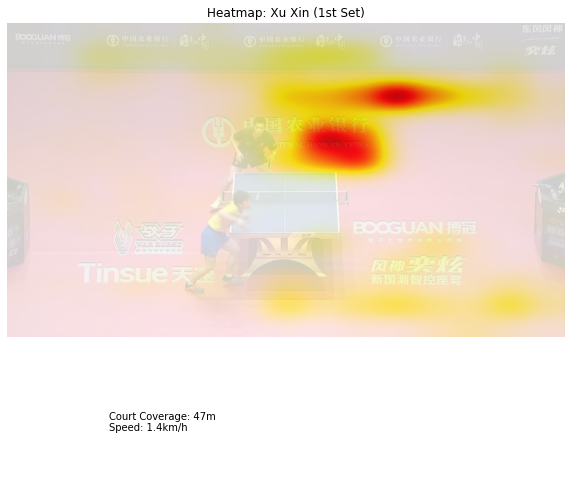

In [133]:
print(len(player_info_2['player_A']['player_coords']))
generate_heatmap(player_info_2['player_A']['player_coords'], player_info_2['player_A']['label'], n_frames/video_fps, bins=15)

2307


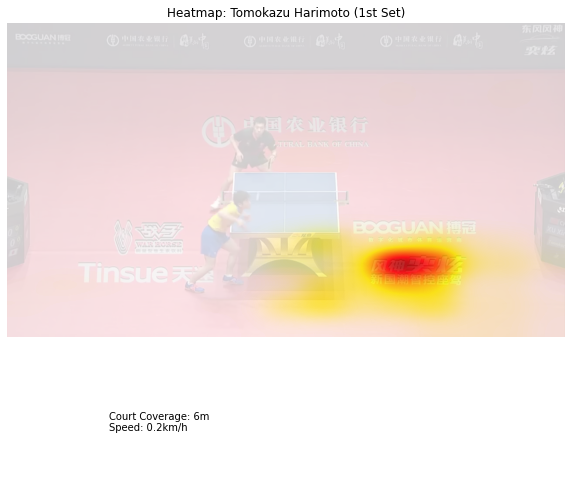

In [134]:
print(len(player_info_2['player_B']['player_coords']))
generate_heatmap(player_info_2['player_B']['player_coords'], player_info_2['player_B']['label'], n_frames/video_fps, bins=15)